In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

# For Figures in Results Section about d18O signal at WDC and what drives it
## End results are figures of the T2M response to SAM, PSA1, PSA2 (by quartile differences) with contours of the T2M field with WDC d18O record
## Will need to focus on 1980-2000 (MERRA, the WDC dates are 1982-2002 bc they are offset by 2 years)

In [2]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import matplotlib.path as mpath
import datetime
import pandas as pd
from scipy.stats.stats import pearsonr
from scipy.stats import ttest_ind
from scipy import signal
from IPython.display import display
import xarray as xr
import dask as da
from dask.distributed import Client, LocalCluster
from dask.diagnostics import ProgressBar
from dask.array.rechunk import rechunk
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.colors as colors
import statsmodels.api as sm
from cartopy.util import add_cyclic_point
import netCDF4
from scipy import stats


%matplotlib inline

In [3]:
############# to be set #############

                         
##Load ERA indice .pkl's
PICKLE_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_Indices_as_CSV_19Nov2018'

##Save figure file path
FIG_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Figures_For_REVIEW_Submission_24March2021'



In [4]:

##Specific to MERRA2, ie, not the same chunk and slices as iCESM
XCHUNK = 240 #Full size chunk seems to make things run quickest
YCHUNK = 121 #Full Y size chunk makes things run quickest
#ZCHUNK = 30 #Full Z size chunk 
TCHUNK = 456  #Full T size

##Find .nc file path
NETCDF_PATH = '/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Save_CTRL_LGM_ERA_Xarrays_as_netcdf_31Oct2018'



In [5]:
#For MERRA, decode_cf needs to be set to True for proper concatenation on T axis
MERRA_DATA = xr.open_dataset(NETCDF_PATH+'/MERRA_DATA.nc')
print(MERRA_DATA)

<xarray.Dataset>
Dimensions:  (lat: 121, lon: 240, time: 456)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
Data variables:
    skint    (time, lat, lon) float32 ...
    sst      (time, lat, lon) float32 ...
    msl      (time, lat, lon) float32 ...
    u10      (time, lat, lon) float32 ...
    v10      (time, lat, lon) float32 ...
    t2m      (time, lat, lon) float32 ...
    tp       (time, lat, lon) float32 ...
    ci       (time, lat, lon) float32 ...


In [6]:
#getting variables in right units 
slp_tmon_merra = MERRA_DATA.msl/100 #hPa
v10_tmon_merra = MERRA_DATA.v10 #in m/s at 10m
u10_tmon_merra = MERRA_DATA.u10 #in m/s at 10m
t2m_tmon_merra = MERRA_DATA.t2m-273.15 #in C
tp_tmon_merra  = MERRA_DATA.tp*60*60*24*1000/1000  #in mm/day
ci_tmon_merra  = MERRA_DATA.ci #in [0-1] fraction of sea ice
sst_tmon_merra = MERRA_DATA.sst #SST in C -- taken care of when making the xarray/.nc file


In [7]:
sst_tmon_merra

<xarray.DataArray 'sst' (time: 456, lat: 121, lon: 240)>
[13242240 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2017-12-01
  * lat      (lat) float64 90.0 88.5 87.0 85.5 84.0 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [8]:
#Open pandas dfs of all indices and ASL information
# pdo_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_tmon.pkl')
# # pdo_index_merra.head(n=5)
# pdo_seas_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_seas.pkl')
# # pdo_seas_mean_index_merra.head(n=5)
# pdo_ann_mean_index_merra = pd.read_pickle(PICKLE_PATH+'/merra_pdo_ann_mean.pkl')
# # pdo_ann_mean_index_merra.head(n=5)

enso_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_tmon.pkl')
# enso_indices_merra.head(n=5)
enso_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_seas.pkl')
# enso_seas_mean_indices_merra.head(n=5)
enso_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_ann_mean.pkl')
# enso_ann_mean_indices_merra.head(n=5)
enso_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_12roll_mean.pkl')
# enso_12roll_mean_indices_merra.head(n=10)
enso_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_6roll_mean.pkl')
# enso_6roll_mean_indices_merra.head(n=5)
enso_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_3roll_mean.pkl')
# enso_3roll_mean_indices_merra.head(n=5)
enso_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_epcs_band_filt.pkl')
# enso_band_filt_indices_merra.head(n=5)

SAM_PSAs_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_tmon.pkl')
# SAM_PSAs_indices_merra.head(n=5)
SAM_PSAs_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_seas.pkl')
# SAM_PSAs_seas_mean_indices_merra.head(n=5)
SAM_PSAs_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_ann_mean.pkl')
# SAM_PSAs_ann_mean_indices_merra.head(n=5)
SAM_PSAs_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_12roll_mean.pkl')
# SAM_PSAs_12roll_mean_indices_merra.head(n=10)
SAM_PSAs_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_6roll_mean.pkl')
# SAM_PSAs_6roll_mean_indices_merra.head(n=5)
SAM_PSAs_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_3roll_mean.pkl')
# SAM_PSAs_3roll_mean_indices_merra.head(n=5)
SAM_PSAs_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_sam_psas_band_filt.pkl')
# SAM_PSAs_band_filt_indices_merra.head(n=5)

# df_d18O_psuedoWDC_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_tmon.pkl')
# # df_d18O_psuedoWDC_tmon_merra.head(n=5)
# d18O_psuedoWDC_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_seas.pkl')
# # d18O_psuedoWDC_seas_mean_merra.head(n=5)
# d18O_psuedoWDC_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_ann_mean.pkl')
# # d18O_psuedoWDC_ann_mean_merra.head(n=5)
# d18O_psuedoWDC_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_12roll_mean.pkl')
# # d18O_psuedoWDC_12roll_mean_merra.head(n=10)
# d18O_psuedoWDC_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_6roll_mean.pkl')
# # d18O_psuedoWDC_6roll_mean_merra.head(n=5)
# d18O_psuedoWDC_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_3roll_mean.pkl')
# # d18O_psuedoWDC_3roll_mean_merra.head(n=5)
# d18O_psuedoWDC_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoWDC_band_filt.pkl')
# # d18O_psuedoWDC_band_filt_merra.head(n=5)

# df_d18O_psuedowestcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_tmon.pkl')
# # df_d18O_psuedowestcore_tmon_merra.head(n=5)
# d18O_psuedowestcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_seas.pkl')
# # d18O_psuedowestcore_seas_mean_merra.head(n=5)
# d18O_psuedowestcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_ann_mean.pkl')
# # d18O_psuedowestcore_ann_mean_merra.head(n=5)
# d18O_psuedowestcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_12roll_mean.pkl')
# # d18O_psuedowestcore_12roll_mean_merra.head(n=10)
# d18O_psuedowestcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_6roll_mean.pkl')
# # d18O_psuedowestcore_6roll_mean_merra.head(n=5)
# d18O_psuedowestcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_3roll_mean.pkl')
# # d18O_psuedowestcore_3roll_mean_merra.head(n=5)
# d18O_psuedowestcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedowestcore_band_filt.pkl')
# # d18O_psuedowestcore_band_filt_merra.head(n=5)

# df_d18O_psuedoeastcore_tmon_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_tmon.pkl')
# # df_d18O_psuedoeastcore_tmon_merra.head(n=5)
# d18O_psuedoeastcore_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_seas.pkl')
# # d18O_psuedoeastcore_seas_mean_merra.head(n=5)
# d18O_psuedoeastcore_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_ann_mean.pkl')
# # d18O_psuedoeastcore_ann_mean_merra.head(n=5)
# d18O_psuedoeastcore_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_12roll_mean.pkl')
# # d18O_psuedoeastcore_12roll_mean_merra.head(n=10)
# d18O_psuedoeastcore_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_6roll_mean.pkl')
# # d18O_psuedoeastcore_6roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_3roll_mean.pkl')
# # d18O_psuedoeastcore_3roll_mean_merra.head(n=5)
# d18O_psuedoeastcore_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_psuedoeastcore_band_filt.pkl')
# # d18O_psuedoeastcore_band_filt_merra.head(n=5)

# d18O_wais_pcs_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_tmon.pkl')
# # d18O_wais_pcs_merra.head(n=5)
# d18O_wais_pcs_seas_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_seas.pkl')
# # d18O_wais_pcs_seas_mean_merra.head(n=5)
# d18O_wais_pcs_ann_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_ann_mean.pkl')
# # d18O_wais_pcs_ann_mean_merra.head(n=5)
# d18O_wais_pcs_12roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_12roll_mean.pkl')
# # d18O_wais_pcs_12roll_mean_merra.head(n=12)
# d18O_wais_pcs_6roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_6roll_mean.pkl')
# # d18O_wais_pcs_6roll_mean_merra.head(n=5)
# d18O_wais_pcs_3roll_mean_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_3roll_mean.pkl')
# # d18O_wais_pcs_3roll_mean_merra.head(n=5)
# d18O_wais_pcs_band_filt_merra = pd.read_pickle(PICKLE_PATH+'/merra_d18O_wais_pcs_band_filt.pkl')
# # d18O_wais_pcs_band_filt_merra.head(n=5)

# monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_tmon.pkl')
# # monthly_Rel_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Rel_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_seas_mean.pkl')
# # Rel_CP_seas_mean_indices_merra.head(n=5)
# Rel_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_ann_mean.pkl')
# # Rel_CP_ann_mean_indices_merra.head(n=5)
# Rel_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_merra.head(n=10)
# Rel_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_merra.head(n=5)
# Rel_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_3roll_mean.pkl')
# # Rel_CP_3roll_mean_indices_merra.head(n=5)
# Rel_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_band_filt.pkl')
# # Rel_CP_band_filt_indices_merra.head(n=5)

# monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_tmon.pkl')
# # monthly_Abs_CP_Anoms_Detrend_Norm_loc_info_merra_df.head(n=5)
# Abs_CP_seas_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_seas_mean.pkl')
# # Abs_CP_seas_mean_indices_merra.head(n=5)
# Abs_CP_ann_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_ann_mean.pkl')
# # Abs_CP_ann_mean_indices_merra.head(n=5)
# Abs_CP_12roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_12roll_mean.pkl')
# # Abs_CP_12roll_mean_indices_merra.head(n=10)
# Abs_CP_6roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_6roll_mean.pkl')
# # Abs_CP_6roll_mean_indices_merra.head(n=5)
# Abs_CP_3roll_mean_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_3roll_mean.pkl')
# # Abs_CP_3roll_mean_indices_merra.head(n=5)
# Abs_CP_band_filt_indices_merra = pd.read_pickle(PICKLE_PATH+'/merra_Abs_CP_band_filt.pkl')
# # Abs_CP_band_filt_indices_merra.head(n=5)



#Raw Rel and Abs CP Info .... needed for actual lon lat position and values
# monthly_Rel_CP_raw_merra_df = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_tmon.pkl')
# monthly_Rel_CP_raw_merra_df.head(n=5)
Rel_CP_djf_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_djf_mean.pkl')
# Rel_CP_djf_mean_indices_raw_merra.head(n=5)
Rel_CP_mam_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_mam_mean.pkl')
# Rel_CP_mam_mean_indices_raw_merra.head(n=5)
Rel_CP_jja_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_jja_mean.pkl')
# Rel_CP_jja_mean_indices_raw_merra.head(n=5)
Rel_CP_son_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_son_mean.pkl')
# Rel_CP_son_mean_indices_raw_merra.head(n=5)
Rel_CP_ann_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_ann_mean.pkl')
# Rel_CP_ann_mean_indices_raw_merra.head(n=5)
# Rel_CP_12roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_12roll_mean.pkl')
# # Rel_CP_12roll_mean_indices_raw_merra.head(n=10)
# Rel_CP_6roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_6roll_mean.pkl')
# # Rel_CP_6roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_3roll_mean_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_ASL_CP_raw_info_3roll_mean.pkl')
# Rel_CP_3roll_mean_indices_raw_merra.head(n=5)
# Rel_CP_band_filt_indices_raw_merra = pd.read_pickle(PICKLE_PATH+'/merra_Rel_CP_Raw_Info_band_filt.pkl')
# # Rel_CP_band_filt_indices_raw_merra.head(n=5)




In [9]:
#Adding Abs CP column to Rel_CP dataframe
Rel_CP_djf_mean_indices_raw_merra['abs_vals'] = (Rel_CP_djf_mean_indices_raw_merra.vals + Rel_CP_djf_mean_indices_raw_merra.sectormean)
Rel_CP_mam_mean_indices_raw_merra['abs_vals'] = (Rel_CP_mam_mean_indices_raw_merra.vals + Rel_CP_mam_mean_indices_raw_merra.sectormean)
Rel_CP_jja_mean_indices_raw_merra['abs_vals'] = (Rel_CP_jja_mean_indices_raw_merra.vals + Rel_CP_jja_mean_indices_raw_merra.sectormean)
Rel_CP_son_mean_indices_raw_merra['abs_vals'] = (Rel_CP_son_mean_indices_raw_merra.vals + Rel_CP_son_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra['abs_vals'] = (Rel_CP_ann_mean_indices_raw_merra.vals + Rel_CP_ann_mean_indices_raw_merra.sectormean)
Rel_CP_ann_mean_indices_raw_merra

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1980-01-01,-4.454987,-73.5,207.0,990.259126,0,985.804138
1981-01-01,-4.978481,-72.0,214.5,987.240688,1,982.262207
1982-01-01,-5.265890,-73.5,205.5,986.160849,2,980.894958
1983-01-01,-5.715246,-70.5,253.5,985.146704,3,979.431458
1984-01-01,-5.524716,-75.0,207.0,986.935604,4,981.410889
1985-01-01,-6.377041,-73.5,214.5,984.389492,5,978.012451
1986-01-01,-5.511735,-75.0,207.0,988.455095,6,982.943359
1987-01-01,-4.600063,-73.5,202.5,986.560756,7,981.960693
1988-01-01,-5.634635,-72.0,210.0,984.990348,8,979.355713


## PART I: 1980-2000 Spatial Correlations between T2M field and WDC d18O (dates are 1982-2002 bc of 2 year offset)



### Detrending and removing climatology from the WDC d18O Record
### Using the WDC Time Series Provided ~04Mar2018, wherein the dD max and mins were forced to Feb and Aug, respectively. (not shifted this time series, shifting the ERA field variable)


In [10]:
#Load WDC core data (Data from 04Mar2019), note, time is not recognized in this format
#From 197501-200412 (Though diffused/recon data ends mid 2003)
df_WDC_d18O_NEW = pd.read_csv('/glade/work/pgoddard/Clay_AA_Research/AA_Tropical_Teleconnections/Core_Data/WDC_1975_through_2004_d18O_Raw_and_Recon_w_New_Age_Model_from_Tyler_04Mar2019.csv', header=0, index_col=0)

#Convert the age_CE to dates with year, month, day 
from datetime import datetime, timedelta, date
list_times = []
for n in np.arange(len(df_WDC_d18O_NEW.index)):
    start = df_WDC_d18O_NEW.index[n]
    year = int(start)
    rem = start - year
    
    base = date(year, 1, 1) #change date to datetime to include hours, mins, and seconds in string
    #result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem)
    #FOR SOME REASON, THE DATES ARE OFF BY ~30 DAYS.... SO I SHIFTED THE DATES BY -30 DAYS TO AGREE WITH THE RESULTS TYLER SENT ME (THIS ALSO GETS MIN IN AUG AND MAX IN FEB)
    result = base + timedelta(seconds=(base.replace(year=base.year + 1) - base).total_seconds() * rem) + timedelta(days=-30)
    #result = pd.to_datetime(result)
    result = str(result)
    list_times.append(result)
    # 2012-07-02 00:00:00
    
#change list_times to DatetimeIndex
list_times = pd.to_datetime(list_times)

#add list times to df_WDC_d18O_NEW
df_WDC_d18O_NEW['time'] = list_times

#replace old index column (age_CE) with our new time column
df_WDC_d18O_NEW.set_index('time', inplace=True, drop=True)

#time is now recognized by pandas
print(df_WDC_d18O_NEW.head(n=5))
print(df_WDC_d18O_NEW.tail(n=80))

###NOTE, LAST FULL YEAR IS 2002###

            d18O_Raw_March  d18O_Recon_March
time                                        
1974-12-16      -32.207243        -31.579767
1975-01-04      -32.176027        -31.470638
1975-01-22      -32.247920        -31.495771
1975-02-09      -32.345494        -31.673388
1975-02-27      -32.558193        -32.007455
            d18O_Raw_March  d18O_Recon_March
time                                        
2000-12-16      -31.611683        -31.531195
2001-01-04      -31.565181        -31.455920
2001-01-22      -31.429787        -31.534647
2001-02-09      -32.065808        -31.771566
2001-02-27      -33.600932        -32.151034
...                    ...               ...
2004-09-16      -37.258762               NaN
2004-10-04      -36.250608               NaN
2004-10-23      -35.441884               NaN
2004-11-10      -34.307748               NaN
2004-11-28      -33.134041               NaN

[80 rows x 2 columns]


            d18O_Raw_March  d18O_Recon_March
time                                        
1982-01-04      -30.994990        -30.343587
1982-01-22      -30.872929        -30.445309
1982-02-09      -30.979063        -30.624032
1982-02-27      -31.068969        -30.865993
1982-03-18      -31.163774        -31.150089
1982-04-05      -31.416159        -31.456125
1982-04-23      -31.609228        -31.764164
1982-05-11      -31.930761        -32.048277
1982-05-30      -32.217032        -32.291075
1982-06-17      -32.363747        -32.478298
1982-07-05      -32.546720        -32.597983
1982-07-23      -32.489790        -32.649478
1982-08-11      -32.546054        -32.630353
1982-08-29      -32.562385        -32.550617
1982-09-16      -32.565523        -32.422053


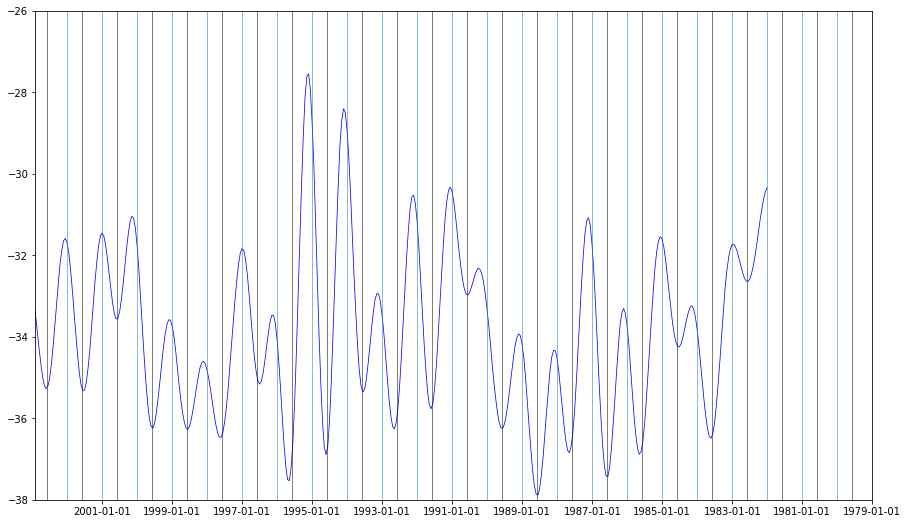

In [11]:
#Create df of detrended WDC d18O record on monthly intevals from 198201-200212 (then match with merra 1980-2000)
#Trough in August and Peak near January

df_WDC_d18O_NEW_198201_200212 = df_WDC_d18O_NEW.loc['1982-01-01':'2002-12-31']
print(df_WDC_d18O_NEW_198201_200212.head(n=15))

plt.figure(figsize=(15,9))
plt.plot(df_WDC_d18O_NEW_198201_200212.d18O_Recon_March, color='blue', linewidth=0.75)

xcoords = [np.datetime64('1979-01-01'), np.datetime64('1980-01-01'), np.datetime64('1981-01-01'), np.datetime64('1982-01-01'), np.datetime64('1983-01-01'), 
           np.datetime64('1984-01-01'), np.datetime64('1985-01-01'), np.datetime64('1986-01-01'), np.datetime64('1987-01-01'), np.datetime64('1988-01-01'),
           np.datetime64('1989-01-01'), np.datetime64('1990-01-01'), np.datetime64('1991-01-01'), np.datetime64('1992-01-01'), np.datetime64('1993-01-01'), 
           np.datetime64('1994-01-01'), np.datetime64('1995-01-01'), np.datetime64('1996-01-01'), np.datetime64('1997-01-01'), np.datetime64('1998-01-01'),
           np.datetime64('1999-01-01'), np.datetime64('2000-01-01'), np.datetime64('2001-01-01'), np.datetime64('2002-01-01'), np.datetime64('2003-01-01')]

for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5)

xcoords = [np.datetime64('1979-08-01'), np.datetime64('1980-08-01'), np.datetime64('1981-08-01'), np.datetime64('1982-08-01'), np.datetime64('1983-08-01'), 
           np.datetime64('1984-08-01'), np.datetime64('1985-08-01'), np.datetime64('1986-08-01'), np.datetime64('1987-08-01'), np.datetime64('1988-08-01'),
           np.datetime64('1989-08-01'), np.datetime64('1990-08-01'), np.datetime64('1991-08-01'), np.datetime64('1992-08-01'), np.datetime64('1993-08-01'), 
           np.datetime64('1994-08-01'), np.datetime64('1995-08-01'), np.datetime64('1996-08-01'), np.datetime64('1997-08-01'), np.datetime64('1998-08-01'),
           np.datetime64('1999-08-01'), np.datetime64('2000-08-01'), np.datetime64('2001-08-01'), np.datetime64('2002-08-01'), np.datetime64('2003-08-01')]
for xc in xcoords:
    plt.axvline(x=xc,linewidth=0.5,color='k')

plt.xlim(np.datetime64('2002-12-01'), np.datetime64('1979-01-01'))  # decreasing time
plt.xticks(np.arange(np.datetime64('1979'), np.datetime64('2003'), 2))
plt.ylim(-38, -26)  # decreasing time
plt.yticks(np.arange(-38, -24, 2))
plt.show()

#Matches figure from Tyler


In [12]:
#Resample such that the 20 pts per year are made into months
#Detrend this monthy WDC Recon Time Series and put back into pd Dataframe
#Detrend first and put into dataframe
#Detrending removes mean!!!

#d18O
d_not_detrend = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March}
print(d_not_detrend)

d = {'time': df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().index, 'd18O_Recon_March': signal.detrend(df_WDC_d18O_NEW_198201_200212.resample('1MS').mean().d18O_Recon_March)}
df_WDC_d18O_NEW_198201_200212_detrend = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend.set_index(df_WDC_d18O_NEW_198201_200212_detrend['time'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=16))

{'time': DatetimeIndex(['1982-01-01', '1982-02-01', '1982-03-01', '1982-04-01',
               '1982-05-01', '1982-06-01', '1982-07-01', '1982-08-01',
               '1982-09-01', '1982-10-01',
               ...
               '2002-03-01', '2002-04-01', '2002-05-01', '2002-06-01',
               '2002-07-01', '2002-08-01', '2002-09-01', '2002-10-01',
               '2002-11-01', '2002-12-01'],
              dtype='datetime64[ns]', name='time', length=252, freq='MS'), 'd18O_Recon_March': time
1982-01-01   -30.394448
1982-02-01   -30.745013
1982-03-01   -31.150089
1982-04-01   -31.610145
1982-05-01   -32.169676
                ...    
2002-08-01   -35.232765
2002-09-01   -34.984753
2002-10-01   -34.476018
2002-11-01   -33.675057
2002-12-01   -33.159919
Freq: MS, Name: d18O_Recon_March, Length: 252, dtype: float64}
                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          3.547851
1982-02-01 1982-02-01          3.196664
1982-03-01 198

       month  d18O_Recon_March
month                         
1          1          1.739821
2          2          1.842327
3          3          1.483292
4          4          0.766365
5          5         -0.361603
6          6         -1.152202
7          7         -1.668557
8          8         -1.806641
9          9         -1.476368
10        10         -0.795825
11        11          0.321896
12        12          1.107495


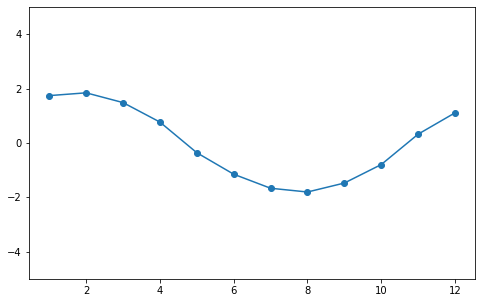

In [13]:
#Create df of detrended WDC_dD_NEW dD record on monthly intevals from 198201-200212 WITH CLIMATOLOGY REMOVED

#Remove climatology second, see below, works best to change into xr data array first
#xarray


#d18O
da_WDC_d18O_NEW_198201_200212_detrend = xr.DataArray(df_WDC_d18O_NEW_198201_200212_detrend.d18O_Recon_March.values, coords={'time': df_WDC_d18O_NEW_198201_200212_detrend.index}, dims=('time'))
# da_WDC_d18O_NEW_198201_200212_detrend

#calculte climatology
da_WDC_d18O_NEW_198201_200212_detrend_climatology = da_WDC_d18O_NEW_198201_200212_detrend.groupby('time.month').mean('time')
# plt.plot(da_WDC_d18O_NEW_198201_200212_detrend_climatology)
# #plt.savefig(FIG_PATH+'/fig01_WDC_d18O_NEW_d18O_climatology.png',bbox_inches='tight', pad_inches=0.01)
# plt.show()

#turn back into pd DataFrame
d = {'month': da_WDC_d18O_NEW_198201_200212_detrend_climatology.coords['month'], 'd18O_Recon_March': da_WDC_d18O_NEW_198201_200212_detrend_climatology.values}
df_WDC_d18O_NEW_198201_200212_detrend_climatology = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend_climatology.set_index(df_WDC_d18O_NEW_198201_200212_detrend_climatology['month'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend_climatology)
plt.figure(figsize=(8,5))
plt.plot(df_WDC_d18O_NEW_198201_200212_detrend_climatology.month.values, df_WDC_d18O_NEW_198201_200212_detrend_climatology.d18O_Recon_March.values, marker='o')
plt.ylim([-5,5])
#plt.savefig(FIG_PATH+'/fig01_WDC_d18O_NEW_d18O_climatology.png',bbox_inches='tight', pad_inches=0.01)
plt.show()



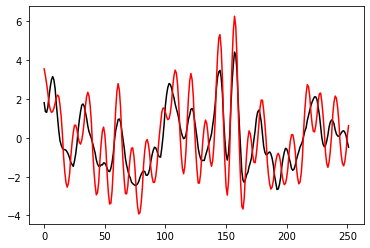

                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          1.808031
1982-02-01 1982-02-01          1.354337
1982-03-01 1982-03-01          1.307673
1982-04-01 1982-04-01          1.563923
1982-05-01 1982-05-01          2.131737


In [14]:
#remove climatology
#d18O
da_WDC_d18O_NEW_198201_200212_detrend_anoms = da_WDC_d18O_NEW_198201_200212_detrend.groupby('time.month') - da_WDC_d18O_NEW_198201_200212_detrend_climatology

plt.plot(da_WDC_d18O_NEW_198201_200212_detrend_anoms,color='k')
plt.plot(da_WDC_d18O_NEW_198201_200212_detrend,color='r')
plt.show()

#turn back into pd DataFrame
d = {'time': da_WDC_d18O_NEW_198201_200212_detrend.coords['time'], 'd18O_Recon_March': da_WDC_d18O_NEW_198201_200212_detrend_anoms.values}
df_WDC_d18O_NEW_198201_200212_detrend_anoms = pd.DataFrame(data=d)
df_WDC_d18O_NEW_198201_200212_detrend_anoms.set_index(df_WDC_d18O_NEW_198201_200212_detrend_anoms['time'], inplace=True, drop=True)
print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))

### Detrending and removing climatology for the T2M variable. (Not using the normalized data here)

In [15]:
#params to be set

#Time period to calc seasonal (monthly) cycle:
time_lo     = '1980-01-01'
time_hi    = '2000-12-31' 

#Define the Tropical Pacific per Jeong et al., (2017)
trop_pac_xhi = 290
trop_pac_xlo = 110
trop_pac_yhi = -20 #Had to reverse hi and lo lat values for ERA
trop_pac_ylo = 20  #Had to reverse hi and lo lat values for ERA

asl_xhi_slice = 298
asl_xlo_slice = 170
asl_yhi_slice = -80 #Had to reverse hi and lo lat values for ERA
asl_ylo_slice = -59.6 #Had to reverse hi and lo lat values for ERA

shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
shem_xlo_slice = 0
shem_yhi_slice = -90 #Had to reverse hi and lo lat values for ERA
shem_ylo_slice = -45 #Had to reverse hi and lo lat values for ERA

shem_yhi = -90 #Had to reverse hi and lo lat values for ERA
shem_ylo = -20  #Had to reverse hi and lo lat values for ERA

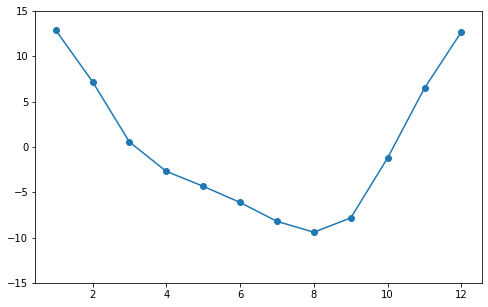

In [16]:
t2m_shem_tmon_merra = t2m_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_merra.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_merra.coords['time'], 'lat': t2m_shem_tmon_merra.coords['lat'],'lon': t2m_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_merra = aa2.where(aa2 != 0.00000, np.nan)

#Create t2m Monthly Climatology at pseudoWDC location from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_merra = t2m_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
plt.figure(figsize=(8,5))
plt.plot(t2m_detrend_shem_climatology_merra.month, t2m_detrend_shem_climatology_merra.sel(lat=-78.63, lon=247.5, method='nearest'), marker='o')
plt.ylim([-15,15])
plt.show()

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_merra = t2m_shem_tmon_detrend_merra.groupby('time.month') - t2m_detrend_shem_climatology_merra


#In case I eventually want to use the normalized dataset, here it is:
#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_merra = (t2m_anoms_shem_tmon_detrend_merra - t2m_anoms_shem_tmon_detrend_merra.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_merra.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_merra


In [17]:
t2m_detrend_shem_climatology_merra

<xarray.DataArray (month: 12, lat: 47, lon: 240)>
array([[[ 1.4752134 ,  1.5269692 ,  1.5859854 , ...,  1.4127748 ,
          1.4304224 ,  1.4328886 ],
        [ 1.6302214 ,  1.6337295 ,  1.6733558 , ...,  1.6555973 ,
          1.6538912 ,  1.6450421 ],
        [ 1.8523043 ,  1.8096285 ,  1.7964401 , ...,  1.9206415 ,
          1.8948812 ,  1.8699992 ],
        ...,
        [22.139479  , 22.159885  , 22.1751    , ..., 22.053968  ,
         22.085419  , 22.114273  ],
        [22.19032   , 22.172531  , 22.154324  , ..., 22.239109  ,
         22.2232    , 22.206985  ],
        [21.47292   , 21.47292   , 21.47292   , ..., 21.47292   ,
         21.47292   , 21.47292   ]],

       [[ 2.4787867 ,  2.5319426 ,  2.5743978 , ...,  2.3379886 ,
          2.365604  ,  2.4054122 ],
        [ 2.5275996 ,  2.5828407 ,  2.6165423 , ...,  2.5188756 ,
          2.5009046 ,  2.5029163 ],
        [ 2.623359  ,  2.6390269 ,  2.6674588 , ...,  2.69037   ,
          2.6523287 ,  2.6494236 ],
...
        [11.754759  , 11.7687435 , 11.779231  , ..., 11.697055  ,
         11.7178955 , 11.737541  ],
        [11.945692  , 11.932168  , 11.919255  , ..., 11.986796  ,
         11.973308  , 11.959678  ],
        [11.476935  , 11.476935  , 11.476935  , ..., 11.476935  ,
         11.476935  , 11.476935  ]],

       [[ 0.08004624,  0.12267249,  0.18588093, ...,  0.09067227,
          0.07259523,  0.06167139],
        [ 0.22123346,  0.23939796,  0.28011793, ...,  0.28014264,
          0.25500342,  0.24071485],
        [ 0.39453688,  0.36881766,  0.37589455, ...,  0.45164073,
          0.39864177,  0.39392334],
        ...,
        [21.969284  , 22.01003   , 22.045353  , ..., 21.822638  ,
         21.874374  , 21.923708  ],
        [22.041584  , 22.030552  , 22.018845  , ..., 22.06932   ,
         22.06047   , 22.051268  ],
        [21.2712    , 21.2712    , 21.2712    , ..., 21.2712    ,
         21.2712    , 21.2712    ]]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [18]:
#Xarray of detrended T2M anomalies from 198001-200012 (monthly)
t2m_anoms_198001_200012_tmon_detrend_merra = t2m_anoms_shem_tmon_detrend_merra
t2m_anoms_198001_200012_tmon_detrend_merra

<xarray.DataArray (time: 252, lat: 47, lon: 240)>
array([[[-0.09779871, -0.12931561, -0.15567422, ..., -0.10944533,
         -0.07914031, -0.08123648],
        [-0.01355267, -0.03906393, -0.05637813, ..., -0.10558856,
         -0.04199088, -0.01681864],
        [ 0.12018597,  0.09238911,  0.03015137, ..., -0.05617964,
          0.00970554,  0.07224059],
        ...,
        [-0.694376  , -0.6479187 , -0.60113716, ..., -0.8314457 ,
         -0.78660583, -0.74067307],
        [-0.25040817, -0.23973465, -0.2282486 , ..., -0.2789154 ,
         -0.26975822, -0.26012802],
        [-0.2544632 , -0.2544632 , -0.2544632 , ..., -0.2544632 ,
         -0.2544632 , -0.2544632 ]],

       [[-0.18339372, -0.16564584, -0.20385718, ..., -0.05127597,
         -0.14017057, -0.18470907],
        [-0.16388345, -0.12840343, -0.09950399, ..., -0.09085321,
         -0.10097361, -0.17540741],
        [-0.05738187, -0.08760858, -0.06606984, ..., -0.23629713,
         -0.09291673, -0.08938026],
...
        [ 4.026743  ,  4.0429325 ,  4.0585337 , ...,  3.9766512 ,
          3.9934502 ,  4.0100937 ],
        [ 4.3666897 ,  4.373168  ,  4.377303  , ...,  4.3390665 ,
          4.347974  ,  4.357278  ],
        [ 3.943532  ,  3.943532  ,  3.943532  , ...,  3.943532  ,
          3.943532  ,  3.943532  ]],

       [[ 0.69113487,  0.62995964,  0.52301955, ...,  0.6406834 ,
          0.6667026 ,  0.68202865],
        [ 0.75943553,  0.74447733,  0.6407462 , ...,  0.58725655,
          0.68647337,  0.7312357 ],
        [ 0.7107049 ,  0.81292784,  0.8173046 , ...,  0.60846174,
          0.6751688 ,  0.70166916],
        ...,
        [-0.17998886, -0.19439125, -0.20853806, ..., -0.13643456,
         -0.15106964, -0.16555977],
        [-0.6001663 , -0.59313583, -0.5822754 , ..., -0.607357  ,
         -0.60477066, -0.6024647 ],
        [-1.043951  , -1.043951  , -1.043951  , ..., -1.043951  ,
         -1.043951  , -1.043951  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-02-01 ... 2000-12-01
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

### Turn monthly data (WDC d18O record and T2M array) into Seasons and Annual Mean

In [19]:
print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))
print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=5))

                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          1.808031
1982-02-01 1982-02-01          1.354337
1982-03-01 1982-03-01          1.307673
1982-04-01 1982-04-01          1.563923
1982-05-01 1982-05-01          2.131737
                 time  d18O_Recon_March
time                                   
1982-01-01 1982-01-01          3.547851
1982-02-01 1982-02-01          3.196664
1982-03-01 1982-03-01          2.790965
1982-04-01 1982-04-01          2.330288
1982-05-01 1982-05-01          1.770134


            d18O_Recon_March
time                        
1982-01-01          1.868674
1983-01-01         -0.890723
1984-01-01          0.815539
1985-01-01         -0.912345
1986-01-01         -0.794855


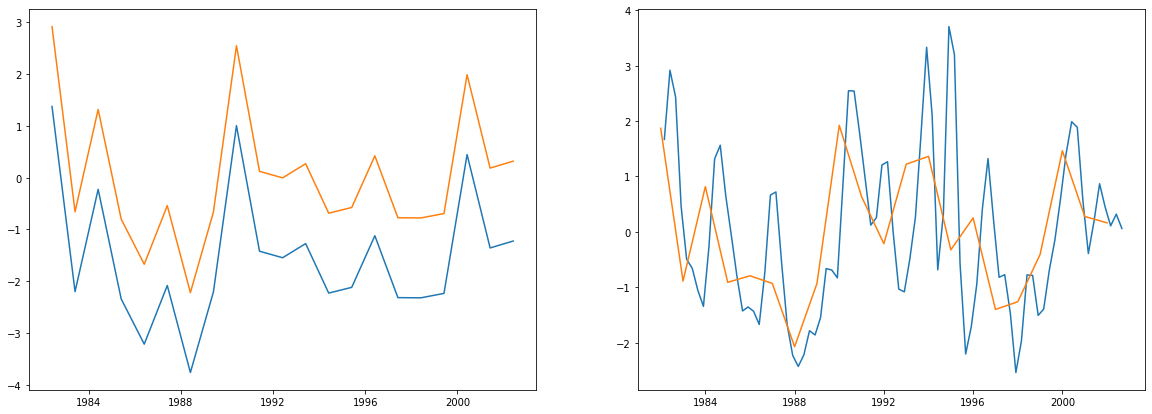

In [20]:
# WDC Seasonal Means:
# Pulling out the Seasonal Time Series and Seasonal ANOM Time Series

# print(df_WDC_d18O_NEW_198201_200212_detrend_anoms.head(n=5))
# print(df_WDC_d18O_NEW_198201_200212_detrend.head(n=5))

#seasonal means from monthly data
df_WDC_seas_1982_2002_detrend = df_WDC_d18O_NEW_198201_200212_detrend[2:(len(df_WDC_d18O_NEW_198201_200212_detrend.index)-1)].resample('3MS', closed='left'  ).mean()
df_WDC_seas_1982_2002_detrend['Seas_Index'] = df_WDC_seas_1982_2002_detrend.index.astype(str).str[5:7]

df_WDC_djf_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '12').dropna()
df_WDC_mam_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '03').dropna()
df_WDC_jja_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '06').dropna()
df_WDC_son_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '09').dropna()

#seasonal means of anoms
df_WDC_seas_1982_2002_detrend_anoms = df_WDC_d18O_NEW_198201_200212_detrend_anoms[2:(len(df_WDC_d18O_NEW_198201_200212_detrend_anoms.index)-1)].resample('3MS', closed='left'  ).mean()
df_WDC_seas_1982_2002_detrend_anoms['Seas_Index'] = df_WDC_seas_1982_2002_detrend_anoms.index.astype(str).str[5:7]
# print(df_WDC_seas_1982_2002_detrend_anoms)

df_WDC_djf_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '12').dropna()
df_WDC_mam_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '03').dropna()
df_WDC_jja_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '06').dropna()
df_WDC_son_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '09').dropna()


# WDC JJA Mean:
plt.figure(figsize=(20,7))
plt.subplot(1,2,1)
plt.plot(df_WDC_jja_1982_2002_detrend.d18O_Recon_March)
plt.plot(df_WDC_jja_1982_2002_detrend_anoms.d18O_Recon_March)
# plt.show()
# Removing the climatology does not change pattern, only centers variability about zero
# Will use the data with climatology removed


# WDC Annual Mean:
df_WDC_ann_mean_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.resample('AS', closed='left').mean()
plt.subplot(1,2,2)
plt.plot(df_WDC_seas_1982_2002_detrend_anoms.d18O_Recon_March)
plt.plot(df_WDC_ann_mean_1982_2002_detrend_anoms.d18O_Recon_March)
print(df_WDC_ann_mean_1982_2002_detrend_anoms.head(n=5))
# Annual cycle looks good

In [21]:
# T2M field in Seasonal Means:
# NOTE, T2M SEASONAL MEANS ARE CENTERED ON CENTER MONTH; in WDC SEASONAL MEANS ARE NUMBERED BY THE FIRST MONTH

rolls_for_seas = t2m_anoms_198001_200012_tmon_detrend_merra.rolling(time=3, min_periods=3, center=True).mean()
djf_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[12::12,:]
mam_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[3::12,:]
jja_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[6::12,:]
son_t2m_anoms_1980_2000_detrend_merra = rolls_for_seas[9::12,:]


#T2M field in Annual Mean:
#Note, time is now list of years 1980, 1980, etc  (not in yyyy-mm-dd)
ann_mean_t2m_anoms_1980_2000_detrend_merra = t2m_anoms_198001_200012_tmon_detrend_merra.groupby('time.year').mean('time')
ann_mean_t2m_anoms_1980_2000_detrend_merra.coords['year']

<xarray.DataArray 'year' (year: 21)>
array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991,
       1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000])
Coordinates:
  * year     (year) int64 1980 1981 1982 1983 1984 ... 1996 1997 1998 1999 2000

### Correlate the WDC time series with T2M field for each season and annual mean -- to get to spatial correlation map with significance contours 

#### calculate the correlation of every row in a 2D array to a 1D array of the same length
#### https://www.quora.com/How-do-I-calculate-the-correlation-of-every-row-in-a-2D-array-to-a-1D-array-of-the-same-length
#### x is 1D, m
#### y is 2D, nXm with second dimension equal in length to length of x, m

In [22]:
#DJF 
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
djf_t2m_anoms_1980_2000_detrend_stack_merra = djf_t2m_anoms_1980_2000_detrend_merra.stack(xy=('lat', 'lon'))
print(djf_t2m_anoms_1980_2000_detrend_stack_merra.shape)

x = df_WDC_djf_1982_2002_detrend_anoms['d18O_Recon_March'].values
y = djf_t2m_anoms_1980_2000_detrend_stack_merra.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
djf_t2m_anoms_1980_2000_detrend_stack_merra['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. 
djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra = djf_t2m_anoms_1980_2000_detrend_stack_merra.unstack('xy')[0]


#MAM
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
mam_t2m_anoms_1980_2000_detrend_stack_merra = mam_t2m_anoms_1980_2000_detrend_merra.stack(xy=('lat', 'lon'))
print(mam_t2m_anoms_1980_2000_detrend_stack_merra.shape)

x = df_WDC_mam_1982_2002_detrend_anoms['d18O_Recon_March'].values
y = mam_t2m_anoms_1980_2000_detrend_stack_merra.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
mam_t2m_anoms_1980_2000_detrend_stack_merra['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. 
mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra = mam_t2m_anoms_1980_2000_detrend_stack_merra.unstack('xy')[0]


#JJA
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
jja_t2m_anoms_1980_2000_detrend_stack_merra = jja_t2m_anoms_1980_2000_detrend_merra.stack(xy=('lat', 'lon'))
print(jja_t2m_anoms_1980_2000_detrend_stack_merra.shape)

x = df_WDC_jja_1982_2002_detrend_anoms['d18O_Recon_March'].values
y = jja_t2m_anoms_1980_2000_detrend_stack_merra.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
jja_t2m_anoms_1980_2000_detrend_stack_merra['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. 
jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra = jja_t2m_anoms_1980_2000_detrend_stack_merra.unstack('xy')[0]


#SON
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
son_t2m_anoms_1980_2000_detrend_stack_merra = son_t2m_anoms_1980_2000_detrend_merra.stack(xy=('lat', 'lon'))
print(son_t2m_anoms_1980_2000_detrend_stack_merra.shape)

x = df_WDC_son_1982_2002_detrend_anoms['d18O_Recon_March'].values
y = son_t2m_anoms_1980_2000_detrend_stack_merra.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearsons = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearson corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
son_t2m_anoms_1980_2000_detrend_stack_merra['pearsons'] = (('xy'), pearsons)

# Unstack `xy` back into lat, lon. 
son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra = son_t2m_anoms_1980_2000_detrend_stack_merra.unstack('xy')[0]


#Annual Mean
# For t2m, Stack lat, lon into single `xy` so we only have two dims instead of three.
ann_mean_t2m_anoms_1980_2000_detrend_stack_merra = ann_mean_t2m_anoms_1980_2000_detrend_merra.stack(xy=('lat', 'lon'))
print(ann_mean_t2m_anoms_1980_2000_detrend_stack_merra.shape)

x = df_WDC_ann_mean_1982_2002_detrend_anoms['d18O_Recon_March'].values
y = ann_mean_t2m_anoms_1980_2000_detrend_stack_merra.T.values
print(x.shape, y.shape)

x_bar = np.mean(x)
x_intermediate = x - x_bar

y_bar = np.mean(y, axis=1) # this flattens y to be (n,) which is a 1D array. The problem is that y is n,m so numpy's broadcasting doesn't know which axis to treat as the one to broadcast over.
y_bar = y_bar[:, np.newaxis] # By adding this extra dimension, we're forcing numpy to treat the 0th axis as the one to broadcast over which makes the next step possible. y_bar is now n,1
y_intermediate = y - y_bar

numerators = y_intermediate.dot(x_intermediate) # or x_intermediate.dot(y_intermediate.T)
x_sq = np.sum(np.square(x_intermediate))
y_sqs = np.sum(np.square(y_intermediate), axis=1)
denominators = np.sqrt(x_sq * y_sqs) # scalar times vector
pearann_means = (numerators/denominators) # numerators is shape (m,) and denominators is shape (m,)

# Add our pearann_mean corr coef data to the stacked Dataset. Telling it that it's one dimension is `xy` (i.e. our stacked latlon).
ann_mean_t2m_anoms_1980_2000_detrend_stack_merra['pearsons'] = (('xy'), pearann_means)

# Unstack `xy` back into lat, lon. 
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra = ann_mean_t2m_anoms_1980_2000_detrend_stack_merra.unstack('xy')[0]


(20, 11280)
(20,) (11280, 20)
(21, 11280)
(21,) (11280, 21)
(21, 11280)
(21,) (11280, 21)
(21, 11280)
(21,) (11280, 21)
(21, 11280)
(21,) (11280, 21)


In [23]:
#Table of critical r value for the Pearson Correlation to be significant at 0.05, 
#For New Scale: years 1980-2000
ann_sigs_n21 = 0.433
seas_sigs_n21 = 0.433
djf_sigs_n20 = 0.444

#NEED TO VERIFY WHEN I KNOW WHAT MY SAMPLE SIZE WILL BE!!!!!!!!!!!!!!!!!!!!!!!

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


WDC d18O Record Corr. with T2M DJF = 0.393


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:48: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


WDC d18O Record Corr. with T2M MAM = 0.174


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:77: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


WDC d18O Record Corr. with T2M JJA = 0.487


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:106: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


WDC d18O Record Corr. with T2M SON = 0.434


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:135: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


WDC d18O Record Corr. with T2M Annual Mean = 0.602


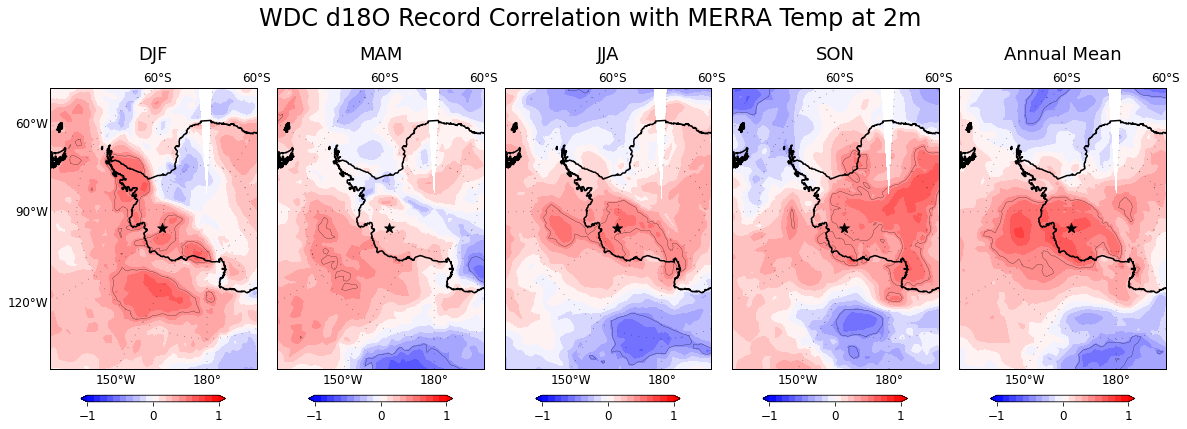

In [24]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('WDC d18O Record Correlation with MERRA Temp at 2m', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-1,1.1,.1)

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
siglevs = [(-1)*djf_sigs_n20, djf_sigs_n20]
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)

print('WDC d18O Record Corr. with T2M DJF =', np.round_(djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
DJF_New = np.round_(djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3)


#MAM
siglevs = [(-1)*seas_sigs_n21, seas_sigs_n21]
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)

print('WDC d18O Record Corr. with T2M MAM =', np.round_(mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
MAM_New = np.round_(mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3)


#JJA
siglevs = [(-1)*seas_sigs_n21, seas_sigs_n21]
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)

print('WDC d18O Record Corr. with T2M JJA =', np.round_(jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
JJA_New = np.round_(jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3)


#SON
siglevs = [(-1)*seas_sigs_n21, seas_sigs_n21]
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)

print('WDC d18O Record Corr. with T2M SON =', np.round_(son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
SON_New = np.round_(son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3)


#Annual Mean
siglevs = [(-1)*ann_sigs_n21, ann_sigs_n21]
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_ticks([-1, 0, 1])
cbar.ax.tick_params(labelsize=12)
plt.clim([-1,1])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons,siglevs,linewidths=0.25,colors='k')

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)

print('WDC d18O Record Corr. with T2M Annual Mean =', np.round_(ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
Annual_Mean_New = np.round_(ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3)



# plt.savefig(FIG_PATH+'/Figure_WDC_d18O_corr_with_MERRA_t2m_Field_1980_2000_04May2020.ps',bbox_inches='tight', pad_inches=0.05)
plt.show()


### Select correlation values that are significant (bounded between -0.433 and 0.444)

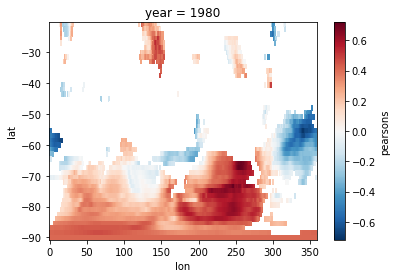

In [25]:
djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded = djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.where(
    (djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra >= 0.44) | (djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra <= -0.44))
mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded = mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.where(
    (mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra >= 0.43) | (mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra <= -0.43))
jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded = jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.where(
    (jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra >= 0.43) | (jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra <= -0.43))
son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded = son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.where(
    (son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra >= 0.43) | (son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra <= -0.43))
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded = ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.where(
    (ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra >= 0.43) | (ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra <= -0.43))
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_bounded.plot()

## PART 2: 1980-2000 Quartile Difference between T2M field and WDC d18O (for WDC dates are 1982-2002 bc of 2 yr offset)

In [26]:
#params to be set
time_lo     = '1980-01-01'
time_hi    = '2000-12-01'  

# trop_pac_xhi = 290
# trop_pac_xlo = 110
# trop_pac_yhi = 20 
# trop_pac_ylo = -20  

# asl_xhi_slice = 298
# asl_xlo_slice = 170
# asl_yhi_slice = -59.6 #need to go a bit passed 60S to get a full grid point
# asl_ylo_slice = -80

# shem_xhi_slice = 362.5 #trying this, doesnt change ... still missing data from 357.5 to 360 
# shem_xlo_slice = 0
# shem_yhi_slice = -45
# shem_ylo_slice = -90

shem_yhi = -90 #reversed hi and lo lat values for ERA
shem_ylo = -20  #reversed hi and lo lat values for ERA

In [27]:
t2m_shem_tmon_merra = t2m_tmon_merra.sel(time=slice(time_lo, time_hi), lat=slice(shem_ylo, shem_yhi))

#Detrend Southern Hem t2m; use of scipy
#has some missing values, need to fill those with zeros 
#requires remapping back to xr dataArray 
#Returns the detrended t2m data 
#the print lines help determine the shape and number of nans

aa1 = signal.detrend(t2m_shem_tmon_merra.fillna(0.), axis=0, type='linear', bp=0)
# print(4, aa1[0,25,11])
# print(5, aa1[0,25,33])
# print(6, np.count_nonzero(aa1[0,:,:]))


aa2 = xr.DataArray(aa1, coords={'time': t2m_shem_tmon_merra.coords['time'], 'lat': t2m_shem_tmon_merra.coords['lat'],'lon': t2m_shem_tmon_merra.coords['lon']}, dims=('time','lat','lon'))
# print(7, aa2[0,25,11].values)
# print(8, aa2[0,25,33].values)
# print(9, np.count_nonzero(aa2[0,:,:]))

t2m_shem_tmon_detrend_merra = aa2.where(aa2 != 0.00000, np.nan)
# t2m_shem_tmon_detrend_merra


#In case I eventually want the t2m to have climatology removed and normalized, that is done below
#Create t2m Monthly Climatology from detrended data using data from time_lo to time_hi
t2m_detrend_shem_climatology_merra = t2m_shem_tmon_detrend_merra.sel(time=slice(time_lo, time_hi)).groupby('time.month').mean('time')
# t2m_detrend_shem_climatology_merra

#Find Southern Hemisphere t2m Anoms using the climatology from time_lo to time_hi
t2m_anoms_shem_tmon_detrend_merra = t2m_shem_tmon_detrend_merra.groupby('time.month') - t2m_detrend_shem_climatology_merra

#Normalize Southern Hemisphere t2m Anoms (from detrended data)
t2m_anoms_shem_tmon_detrend_norm_merra = (t2m_anoms_shem_tmon_detrend_merra - t2m_anoms_shem_tmon_detrend_merra.mean(dim='time'))/t2m_anoms_shem_tmon_detrend_merra.std(dim='time')
# t2m_anoms_shem_tmon_detrend_norm_merra


### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile SAM across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [28]:
SAM_PSAs_seas_mean_indices_merra.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1980-03-01,-1.069458,0.236233,-0.549796,03
1980-06-01,-0.394065,-0.462641,-0.779531,06
1980-09-01,-0.591505,0.042762,0.298846,09
1980-12-01,0.036406,0.092091,-0.021163,12
1981-03-01,-0.690965,-0.213709,0.451755,03


#### Change Field variable into seasonal means and rolls and annual mean

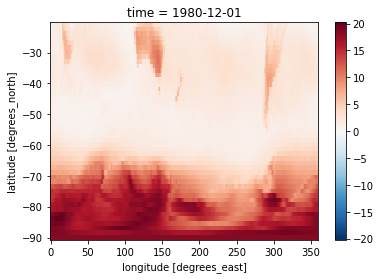

In [29]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
t2m_shem_seas_mean_detrend_merra = t2m_shem_tmon_detrend_merra[2:(len(t2m_shem_tmon_detrend_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
t2m_shem_seas_mean_detrend_merra[3].plot()

<xarray.DataArray (time: 20, lat: 47, lon: 240)>
array([[[ 0.94242543,  0.9874185 ,  1.03512   , ...,  0.7675101 ,
          0.8076916 ,  0.87875366],
        [ 1.0238901 ,  1.0464859 ,  1.0964693 , ...,  0.8762455 ,
          0.9078922 ,  0.9829127 ],
        [ 1.1397768 ,  1.1149578 ,  1.142601  , ...,  1.0781981 ,
          1.0550283 ,  1.1182791 ],
        ...,
        [18.692495  , 18.709274  , 18.72103   , ..., 18.621132  ,
         18.647131  , 18.67143   ],
        [18.837282  , 18.812414  , 18.788584  , ..., 18.914341  ,
         18.889132  , 18.863434  ],
        [18.328161  , 18.328161  , 18.328161  , ..., 18.328161  ,
         18.328161  , 18.328161  ]],

       [[ 1.0607802 ,  1.1172848 ,  1.2103411 , ...,  0.8812256 ,
          0.9274826 ,  0.9617119 ],
        [ 1.1097012 ,  1.1697019 ,  1.2253628 , ...,  0.9581871 ,
          0.9784005 ,  1.0461591 ],
        [ 1.1284949 ,  1.2034162 ,  1.2072874 , ...,  1.0561867 ,
          1.0252018 ,  1.0616621 ],
...
        [18.48

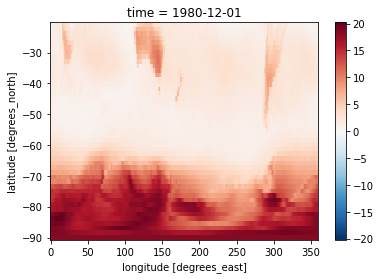

In [30]:
#Seperating out those seasonal means of the field variable
def is_djf(month):
    return (month == 12)

def is_mam(month):
    return (month == 3)

def is_jja(month):
    return (month == 6)

def is_son(month):
    return (month == 9)

djf_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_djf(t2m_shem_seas_mean_detrend_merra['time.month']))
mam_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_mam(t2m_shem_seas_mean_detrend_merra['time.month']))
jja_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_jja(t2m_shem_seas_mean_detrend_merra['time.month']))
son_t2m_shem_seas_mean_detrend_merra = t2m_shem_seas_mean_detrend_merra.sel(time=is_son(t2m_shem_seas_mean_detrend_merra['time.month']))

#note, the first djf is dated for the first year because the 3-month mean is labeled by the first month
djf_t2m_shem_seas_mean_detrend_merra[0].plot()
print(djf_t2m_shem_seas_mean_detrend_merra)

#In case I need to add NaNs in djf, something like this may work:
# #need to add back in at time=0 a row of nans for djf, else it has 47 instead of 48 points
# nan_slice_for_djf = djfmean_T2M_tmon_merra_data[0:1,:,:]
# nan_slice_for_djf = nan_slice_for_djf.where(nan_slice_for_djf == 99999.)
# djfmean_T2M_tmon_merra_data = xr.concat([nan_slice_for_djf, djfmean_T2M_tmon_merra_data], dim='time')
# #djfmean_T2M_tmon_merra_data

In [31]:
#Field variable with 3,6,12 roll and annual mean

t2m_shem_ann_mean_detrend_merra = t2m_shem_tmon_detrend_merra.resample(time='AS').mean(dim='time')
#t2m_shem_ann_mean_detrend_merra

In [32]:
#Find SAM values for each of the 5 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values
#NEED TO SELECT ERA INDICE VALUES FROM 1980-2000 (NOT FULL RECORD)

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
SAM_djf_mean_merra = pd.DataFrame(data=d)
SAM_djf_mean_merra = SAM_djf_mean_merra.loc['1980-01-01':'1999-12-31'] #n=21 for djf
print(SAM_djf_mean_merra)

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
SAM_mam_mean_merra = pd.DataFrame(data=d)
SAM_mam_mean_merra = SAM_mam_mean_merra.loc['1980-01-01':'2000-12-31']
# SAM_mam_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
SAM_jja_mean_merra = pd.DataFrame(data=d)
SAM_jja_mean_merra = SAM_jja_mean_merra.loc['1980-01-01':'2000-12-31']
# SAM_jja_mean_merra

d = {'SAM': SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.SAM.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
SAM_son_mean_merra = pd.DataFrame(data=d)
SAM_son_mean_merra = SAM_son_mean_merra.loc['1980-01-01':'2000-12-31']
# SAM_son_mean_merra

d = {'SAM': SAM_PSAs_ann_mean_indices_merra.SAM.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.SAM.dropna()),1)}
SAM_ann_mean_merra = pd.DataFrame(data=d)
SAM_ann_mean_merra = SAM_ann_mean_merra.loc['1980-01-01':'2000-12-31']
# SAM_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'SAM'
#Note, head is lower (sorted from low to high)
SAM_djf_mean_lower_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_lower_merra
SAM_djf_mean_upper_merra = SAM_djf_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_djf_mean_merra.indice.size/4))).indice.tolist()
# SAM_djf_mean_upper_merra

SAM_mam_mean_lower_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_lower_merra
SAM_mam_mean_upper_merra = SAM_mam_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_mam_mean_merra.indice.size/4))).indice.tolist()
# SAM_mam_mean_upper_merra

SAM_jja_mean_lower_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_lower_merra
SAM_jja_mean_upper_merra = SAM_jja_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_jja_mean_merra.indice.size/4))).indice.tolist()
# SAM_jja_mean_upper_merra

SAM_son_mean_lower_merra = SAM_son_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_lower_merra
SAM_son_mean_upper_merra = SAM_son_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_son_mean_merra.indice.size/4))).indice.tolist()
# SAM_son_mean_upper_merra

SAM_ann_mean_lower_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).head(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_lower_merra
SAM_ann_mean_upper_merra = SAM_ann_mean_merra.sort_values(by=['SAM']).tail(n=(round(SAM_ann_mean_merra.indice.size/4))).indice.tolist()
# SAM_ann_mean_upper_merra

                 SAM  indice
time                        
1980-12-01  0.036406       0
1981-12-01  0.501447       1
1982-12-01 -1.380463       2
1983-12-01 -0.325491       3
1984-12-01 -0.765419       4
1985-12-01 -0.050340       5
1986-12-01 -0.292968       6
1987-12-01  0.050383       7
1988-12-01  0.752202       8
1989-12-01  0.135157       9
1990-12-01  0.233134      10
1991-12-01 -1.191322      11
1992-12-01 -0.497165      12
1993-12-01  0.639215      13
1994-12-01  0.623462      14
1995-12-01  0.257199      15
1996-12-01 -0.207854      16
1997-12-01  0.009148      17
1998-12-01  0.766566      18
1999-12-01  1.158896      19


In [33]:
SAM_djf_mean_lower_merra

[2, 11, 4, 12, 3]

In [34]:
SAM_djf_mean_upper_merra

[14, 13, 8, 18, 19]

In [35]:
SAM_mam_mean_lower_merra

[10, 12, 0, 6, 1]

In [36]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=21, so no need to crop the time series)
djf_t2m_w_upper_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_upper_merra)
djf_t2m_w_lower_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_t2m_w_upper_SAM_detrend_merra
# djf_t2m_w_lower_SAM_detrend_merra

#mam
mam_t2m_w_upper_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_upper_merra)
mam_t2m_w_lower_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_t2m_w_upper_SAM_detrend_merra
# mam_t2m_w_lower_SAM_detrend_merra

#jja
jja_t2m_w_upper_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_upper_merra)
jja_t2m_w_lower_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_t2m_w_upper_SAM_detrend_merra
# jja_t2m_w_lower_SAM_detrend_merra

#son
son_t2m_w_upper_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_upper_merra)
son_t2m_w_lower_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_lower_merra)
son_t2m_w_upper_SAM_detrend_merra
# son_t2m_w_lower_SAM_detrend_merra

#ann mean
ann_mean_t2m_w_upper_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_upper_merra)
ann_mean_t2m_w_lower_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_SAM_detrend_merra
# ann_mean_t2m_w_lower_SAM_detrend_merra


In [37]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_SAM_detrend_merra
djf_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_SAM_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_SAM_detrend_merra
mam_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_SAM_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_SAM_detrend_merra
jja_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_SAM_detrend_merra

#son
son_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_SAM_detrend_merra
son_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_SAM_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra



In [38]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, Seasonal, ann mean df = 5+5-2 = 8 ; +- 2.31

djf_t2m_change_due_to_SAM_ttest_stats_merra, djf_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_SAM_detrend_merra, djf_t2m_w_lower_SAM_detrend_merra, axis=0)

mam_t2m_change_due_to_SAM_ttest_stats_merra, mam_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_SAM_detrend_merra, mam_t2m_w_lower_SAM_detrend_merra, axis=0)

jja_t2m_change_due_to_SAM_ttest_stats_merra, jja_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_SAM_detrend_merra, jja_t2m_w_lower_SAM_detrend_merra, axis=0)

son_t2m_change_due_to_SAM_ttest_stats_merra, son_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_SAM_detrend_merra, son_t2m_w_lower_SAM_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_SAM_ttest_stats_merra, ann_mean_t2m_change_due_to_SAM_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_SAM_detrend_merra, ann_mean_t2m_w_lower_SAM_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.949419453961331 -5.868271125017964


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.584486087396499 -5.822051709242987


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.34555687090517 -7.912657864689322


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:257: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.4441684453182 -7.677535094758445


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:336: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.9732498543960215 -5.88808600756497


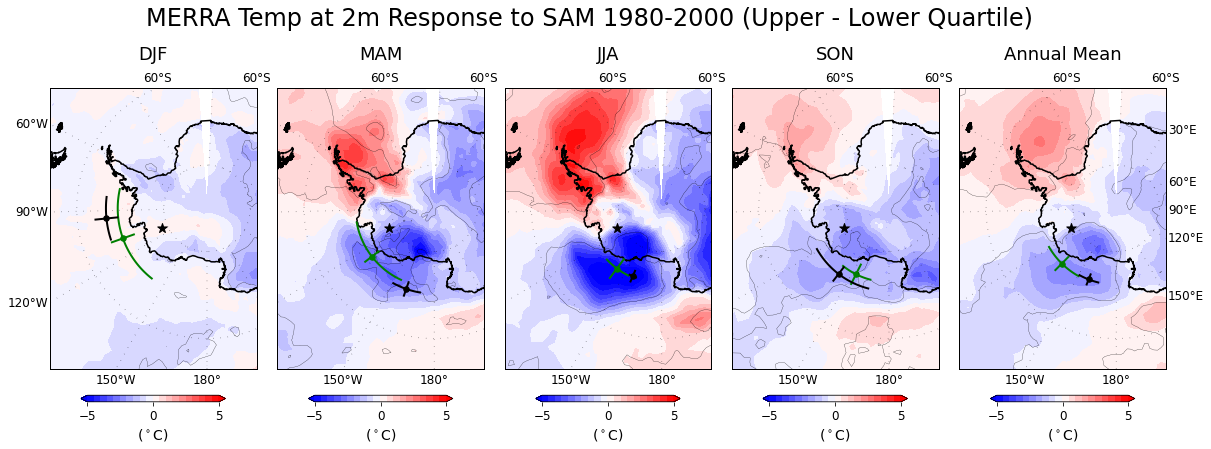

In [39]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to SAM 1980-2000 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.31,2.31] #good for other seasons and annual mean
levels_contour_djf = [-2.31, 2.31] #good for djf

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_SAM_ttest_stats_merra,levels_contour_djf,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_SAM_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_SAM_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-son_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-son_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_SAM_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_SAM_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_SAM_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_SAM_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_SAM_Quartiles_04May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.31,2.31] for djf and bounded between [-2.31,2.31] for all other seasons and annual mean)

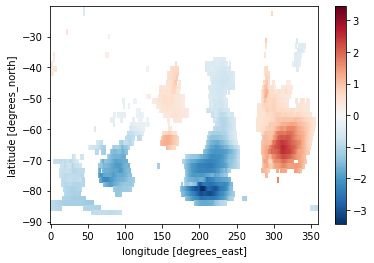

In [40]:
djf_t2m_quart_diff_due_to_SAM_merra = (djf_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-djf_t2m_w_lower_SAM_detrend_merra.mean(axis=0))
djf_t2m_quart_diff_due_to_SAM_merra_bounded = djf_t2m_quart_diff_due_to_SAM_merra.where((djf_t2m_change_due_to_SAM_ttest_stats_merra <= -2.31) | (djf_t2m_change_due_to_SAM_ttest_stats_merra >= 2.31))
mam_t2m_quart_diff_due_to_SAM_merra = (mam_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-mam_t2m_w_lower_SAM_detrend_merra.mean(axis=0))
mam_t2m_quart_diff_due_to_SAM_merra_bounded = mam_t2m_quart_diff_due_to_SAM_merra.where((mam_t2m_change_due_to_SAM_ttest_stats_merra <= -2.31) | (mam_t2m_change_due_to_SAM_ttest_stats_merra >= 2.31))
jja_t2m_quart_diff_due_to_SAM_merra = (jja_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-jja_t2m_w_lower_SAM_detrend_merra.mean(axis=0))
jja_t2m_quart_diff_due_to_SAM_merra_bounded = jja_t2m_quart_diff_due_to_SAM_merra.where((jja_t2m_change_due_to_SAM_ttest_stats_merra <= -2.31) | (jja_t2m_change_due_to_SAM_ttest_stats_merra >= 2.31))
son_t2m_quart_diff_due_to_SAM_merra = (son_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-son_t2m_w_lower_SAM_detrend_merra.mean(axis=0))
son_t2m_quart_diff_due_to_SAM_merra_bounded = son_t2m_quart_diff_due_to_SAM_merra.where((son_t2m_change_due_to_SAM_ttest_stats_merra <= -2.31) | (son_t2m_change_due_to_SAM_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_SAM_merra = (ann_mean_t2m_w_upper_SAM_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_SAM_detrend_merra.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_SAM_merra_bounded = ann_mean_t2m_quart_diff_due_to_SAM_merra.where((ann_mean_t2m_change_due_to_SAM_ttest_stats_merra <= -2.31) | (ann_mean_t2m_change_due_to_SAM_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_SAM_merra_bounded.plot()

## PART 3.1: Finalize Figure - For SAM, T2M, and WDC d18O
### 1980-2000


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


978.2886596679688 985.9490234375


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


975.0553588867188 984.8770629882813


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:190: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


973.0657592773438 981.8523193359375


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:270: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


971.544287109375 977.5209106445312


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


976.6399658203125 981.6315185546875
0.289
-1.706
-1.522
-1.485
-0.771


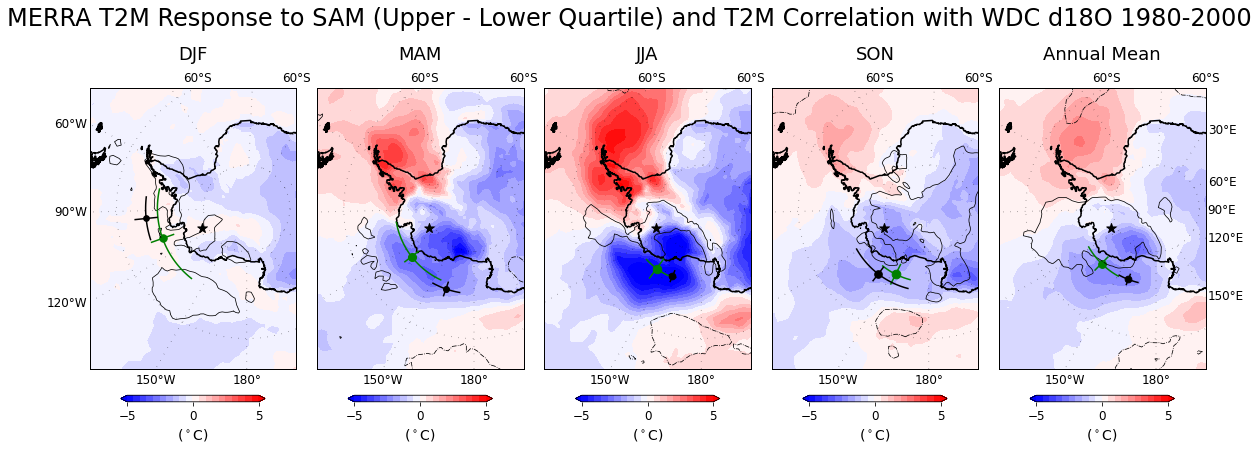

In [41]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA T2M Response to SAM (Upper - Lower Quartile) and T2M Correlation with WDC d18O 1980-2000', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_SAM_merra_fin, lons = add_cyclic_point(djf_t2m_quart_diff_due_to_SAM_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_quart_diff_due_to_SAM_merra_fin, lons = add_cyclic_point(mam_t2m_quart_diff_due_to_SAM_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_quart_diff_due_to_SAM_merra_fin, lons = add_cyclic_point(jja_t2m_quart_diff_due_to_SAM_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_quart_diff_due_to_SAM_merra_fin, lons = add_cyclic_point(son_t2m_quart_diff_due_to_SAM_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_quart_diff_due_to_SAM_merra_fin, lons = add_cyclic_point(ann_mean_t2m_quart_diff_due_to_SAM_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)

djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour_djf = [-.444,.444] #good for other seasons and annual mean
levels_contour = [-.433,.433] #good for other seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_SAM_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour_djf,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=60) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_SAM_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean(),mam_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_SAM_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_SAM_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean(),son_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_SAM_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.abs_vals.mean())    
    
# plt.savefig(FIG_PATH+'/Figure_MERRA_Section_2_Figure_T2M_WDC_and_SAM_1980_2000_04May2020.ps',bbox_inches='tight', pad_inches=0.02)    

#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_SAM_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_SAM_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_SAM_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_SAM_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_SAM_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))



plt.show()

## PART 2.2: 1980-2000 Quartile Difference between T2M field and PSA1



### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile PSA1 across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [42]:
SAM_PSAs_seas_mean_indices_merra.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1980-03-01,-1.069458,0.236233,-0.549796,03
1980-06-01,-0.394065,-0.462641,-0.779531,06
1980-09-01,-0.591505,0.042762,0.298846,09
1980-12-01,0.036406,0.092091,-0.021163,12
1981-03-01,-0.690965,-0.213709,0.451755,03


#### Change Field variable into seasonal means and rolls and annual mean

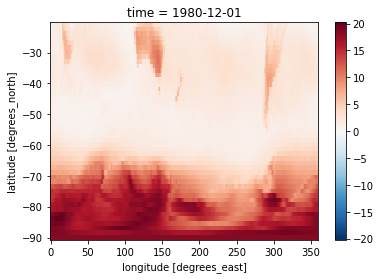

In [43]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
t2m_shem_seas_mean_detrend_merra = t2m_shem_tmon_detrend_merra[2:(len(t2m_shem_tmon_detrend_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
t2m_shem_seas_mean_detrend_merra[3].plot()

In [44]:
#Find SAM values for each of the 5 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values
#NEED TO SELECT ERA INDICE VALUES FROM 1980-2000 (NOT FULL RECORD)

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA1_djf_mean_merra = pd.DataFrame(data=d)
PSA1_djf_mean_merra = PSA1_djf_mean_merra.loc['1980-01-01':'1999-12-31'] #n=21 for djf
print(PSA1_djf_mean_merra)

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA1_mam_mean_merra = pd.DataFrame(data=d)
PSA1_mam_mean_merra = PSA1_mam_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA1_mam_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA1_jja_mean_merra = pd.DataFrame(data=d)
PSA1_jja_mean_merra = PSA1_jja_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA1_jja_mean_merra

d = {'PSA1': SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA1.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA1_son_mean_merra = pd.DataFrame(data=d)
PSA1_son_mean_merra = PSA1_son_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA1_son_mean_merra

d = {'PSA1': SAM_PSAs_ann_mean_indices_merra.PSA1.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA1.dropna()),1)}
PSA1_ann_mean_merra = pd.DataFrame(data=d)
PSA1_ann_mean_merra = PSA1_ann_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA1_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA1'
#Note, head is lower (sorted from low to high)
PSA1_djf_mean_lower_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_lower_merra
PSA1_djf_mean_upper_merra = PSA1_djf_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA1_djf_mean_upper_merra

PSA1_mam_mean_lower_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_lower_merra
PSA1_mam_mean_upper_merra = PSA1_mam_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA1_mam_mean_upper_merra

PSA1_jja_mean_lower_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_lower_merra
PSA1_jja_mean_upper_merra = PSA1_jja_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA1_jja_mean_upper_merra

PSA1_son_mean_lower_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_lower_merra
PSA1_son_mean_upper_merra = PSA1_son_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_son_mean_merra.indice.size/4))).indice.tolist()
# PSA1_son_mean_upper_merra

PSA1_ann_mean_lower_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).head(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_lower_merra
PSA1_ann_mean_upper_merra = PSA1_ann_mean_merra.sort_values(by=['PSA1']).tail(n=(round(PSA1_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA1_ann_mean_upper_merra

                PSA1  indice
time                        
1980-12-01  0.092091       0
1981-12-01 -0.418245       1
1982-12-01  0.454740       2
1983-12-01 -0.080510       3
1984-12-01 -0.815031       4
1985-12-01 -0.358133       5
1986-12-01 -0.140678       6
1987-12-01 -0.254771       7
1988-12-01 -0.860176       8
1989-12-01 -0.819908       9
1990-12-01  0.036946      10
1991-12-01  0.463779      11
1992-12-01  0.176359      12
1993-12-01 -0.035373      13
1994-12-01  0.124101      14
1995-12-01  0.209625      15
1996-12-01 -0.325570      16
1997-12-01  0.028178      17
1998-12-01 -0.527771      18
1999-12-01  1.044675      19


In [45]:
PSA1_djf_mean_lower_merra

[8, 9, 4, 18, 1]

In [46]:
PSA1_djf_mean_upper_merra

[12, 15, 2, 11, 19]

In [47]:
PSA1_mam_mean_lower_merra

[20, 16, 8, 3, 5]

In [48]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=21, so no need to crop the time series)
djf_t2m_w_upper_PSA1_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_djf_mean_upper_merra)
djf_t2m_w_lower_PSA1_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_djf_mean_lower_merra)
# djf_t2m_w_upper_PSA1_detrend_merra
# djf_t2m_w_lower_PSA1_detrend_merra

#mam
mam_t2m_w_upper_PSA1_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_mam_mean_upper_merra)
mam_t2m_w_lower_PSA1_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_mam_mean_lower_merra)
# mam_t2m_w_upper_PSA1_detrend_merra
# mam_t2m_w_lower_PSA1_detrend_merra

#jja
jja_t2m_w_upper_PSA1_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_jja_mean_upper_merra)
jja_t2m_w_lower_PSA1_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_jja_mean_lower_merra)
# jja_t2m_w_upper_PSA1_detrend_merra
# jja_t2m_w_lower_PSA1_detrend_merra

#son
son_t2m_w_upper_PSA1_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_son_mean_upper_merra)
son_t2m_w_lower_PSA1_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA1_son_mean_lower_merra)
son_t2m_w_upper_PSA1_detrend_merra
# son_t2m_w_lower_PSA1_detrend_merra

#ann mean
ann_mean_t2m_w_upper_PSA1_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA1_ann_mean_upper_merra)
ann_mean_t2m_w_lower_PSA1_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA1_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_PSA1_detrend_merra
# ann_mean_t2m_w_lower_PSA1_detrend_merra


In [49]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA1_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_PSA1_detrend_merra
djf_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA1_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_PSA1_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA1_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_PSA1_detrend_merra
mam_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA1_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_PSA1_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA1_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_PSA1_detrend_merra
jja_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA1_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_PSA1_detrend_merra

#son
son_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA1_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_PSA1_detrend_merra
son_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA1_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_PSA1_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA1_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra
ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA1_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra



In [50]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, df = 5+5-2 = 8 ; +- 2.31
#Seasonal, df=6+6-2 = 10 ; critical value = +- 2.31
#ann mean, df =6+6-2 = 10 ; critical value = +- 2.31

djf_t2m_change_due_to_PSA1_ttest_stats_merra, djf_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_PSA1_detrend_merra, djf_t2m_w_lower_PSA1_detrend_merra, axis=0)

mam_t2m_change_due_to_PSA1_ttest_stats_merra, mam_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_PSA1_detrend_merra, mam_t2m_w_lower_PSA1_detrend_merra, axis=0)

jja_t2m_change_due_to_PSA1_ttest_stats_merra, jja_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_PSA1_detrend_merra, jja_t2m_w_lower_PSA1_detrend_merra, axis=0)

son_t2m_change_due_to_PSA1_ttest_stats_merra, son_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_PSA1_detrend_merra, son_t2m_w_lower_PSA1_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra, ann_mean_t2m_change_due_to_PSA1_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_PSA1_detrend_merra, ann_mean_t2m_w_lower_PSA1_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.238718430965401 -5.57214798757177


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.233485040307983 -7.003419171472023


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-10.063524944960273 -8.074066499211835


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:257: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.8067947061334735 -7.503172078050989


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:336: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.109132046586614 -5.8208767459243065


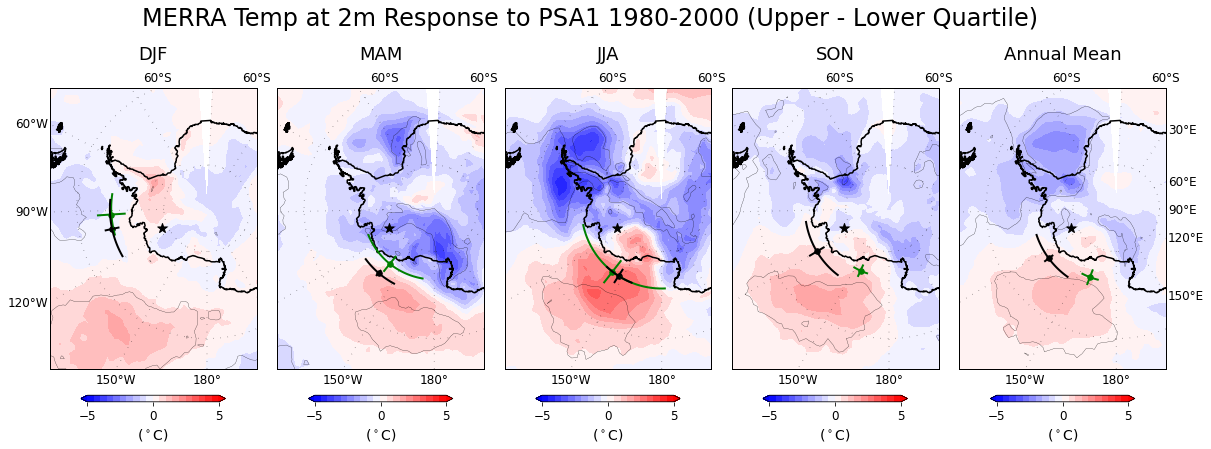

In [51]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to PSA1 1980-2000 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.31,2.31] #good for other seasons and annual mean
levels_contour_djf = [-2.31, 2.31] #good for djf

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_PSA1_ttest_stats_merra,levels_contour_djf,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_PSA1_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_PSA1_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_PSA1_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_PSA1_Quartiles_04May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.31,2.31] for djf and bounded between [-2.31,2.31] for all other seasons and annual mean)

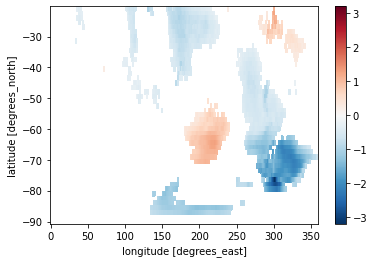

In [52]:
djf_t2m_quart_diff_due_to_PSA1_merra = (djf_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA1_detrend_merra.mean(axis=0))
djf_t2m_quart_diff_due_to_PSA1_merra_bounded = djf_t2m_quart_diff_due_to_PSA1_merra.where((djf_t2m_change_due_to_PSA1_ttest_stats_merra <= -2.31) | (djf_t2m_change_due_to_PSA1_ttest_stats_merra >= 2.31))
mam_t2m_quart_diff_due_to_PSA1_merra = (mam_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA1_detrend_merra.mean(axis=0))
mam_t2m_quart_diff_due_to_PSA1_merra_bounded = mam_t2m_quart_diff_due_to_PSA1_merra.where((mam_t2m_change_due_to_PSA1_ttest_stats_merra <= -2.31) | (mam_t2m_change_due_to_PSA1_ttest_stats_merra >= 2.31))
jja_t2m_quart_diff_due_to_PSA1_merra = (jja_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA1_detrend_merra.mean(axis=0))
jja_t2m_quart_diff_due_to_PSA1_merra_bounded = jja_t2m_quart_diff_due_to_PSA1_merra.where((jja_t2m_change_due_to_PSA1_ttest_stats_merra <= -2.31) | (jja_t2m_change_due_to_PSA1_ttest_stats_merra >= 2.31))
son_t2m_quart_diff_due_to_PSA1_merra = (son_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA1_detrend_merra.mean(axis=0))
son_t2m_quart_diff_due_to_PSA1_merra_bounded = son_t2m_quart_diff_due_to_PSA1_merra.where((son_t2m_change_due_to_PSA1_ttest_stats_merra <= -2.31) | (son_t2m_change_due_to_PSA1_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_PSA1_merra = (ann_mean_t2m_w_upper_PSA1_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA1_detrend_merra.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_PSA1_merra_bounded = ann_mean_t2m_quart_diff_due_to_PSA1_merra.where((ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra <= -2.31) | (ann_mean_t2m_change_due_to_PSA1_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_PSA1_merra_bounded.plot()

## PART 3.2: Finalize Figure - For PSA1, T2M, and WDC d18O
### 1980-2000


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


983.5299194335937 980.3166381835938


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


978.5336181640625 976.6632934570313


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:190: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


979.8380859375 974.458349609375


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:270: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


976.8770141601562 972.9532836914062
981.194970703125 976.9737060546875
0.186
-2.153
-1.277
-0.698
-0.706


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


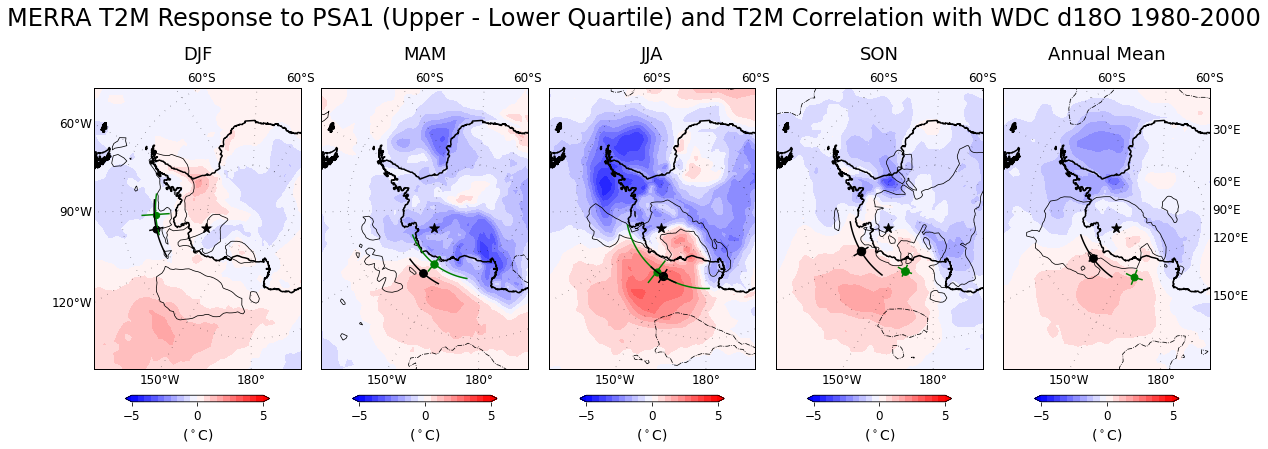

In [53]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA T2M Response to PSA1 (Upper - Lower Quartile) and T2M Correlation with WDC d18O 1980-2000', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_PSA1_merra_fin, lons = add_cyclic_point(djf_t2m_quart_diff_due_to_PSA1_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_quart_diff_due_to_PSA1_merra_fin, lons = add_cyclic_point(mam_t2m_quart_diff_due_to_PSA1_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_quart_diff_due_to_PSA1_merra_fin, lons = add_cyclic_point(jja_t2m_quart_diff_due_to_PSA1_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_quart_diff_due_to_PSA1_merra_fin, lons = add_cyclic_point(son_t2m_quart_diff_due_to_PSA1_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_quart_diff_due_to_PSA1_merra_fin, lons = add_cyclic_point(ann_mean_t2m_quart_diff_due_to_PSA1_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)

djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour_djf = [-.433,.433] #good for other seasons and annual mean
levels_contour = [-.423,.423] #good for other seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_PSA1_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour_djf,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=60) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean(),djf_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_PSA1_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean(),mam_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_PSA1_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean(),jja_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_PSA1_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean(),son_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_PSA1_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA1_detrend_merra.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA1_detrend_merra.abs_vals.mean())    
    
# plt.savefig(FIG_PATH+'/Figure_MERRA_Section_2_Figure_T2M_WDC_and_PSA1_1980_2000_04May2020.ps',bbox_inches='tight', pad_inches=0.02)   
      
#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_PSA1_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_PSA1_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_PSA1_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_PSA1_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_PSA1_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


plt.show()

## PART 2.3: 1980-2000 Quartile Difference between T2M field and PSA2



### Find the Difference in T2M values due to Upper Quartile vs. Lower Quartile PSA2 across the 5 time periods

### Calculate the significance of the difference and mark with contours 

In [54]:
SAM_PSAs_seas_mean_indices_merra.head(n=5)

,SAM,PSA1,PSA2,Seas_Index
time,,,,
1980-03-01,-1.069458,0.236233,-0.549796,03
1980-06-01,-0.394065,-0.462641,-0.779531,06
1980-09-01,-0.591505,0.042762,0.298846,09
1980-12-01,0.036406,0.092091,-0.021163,12
1981-03-01,-0.690965,-0.213709,0.451755,03


#### Change Field variable into seasonal means and rolls and annual mean

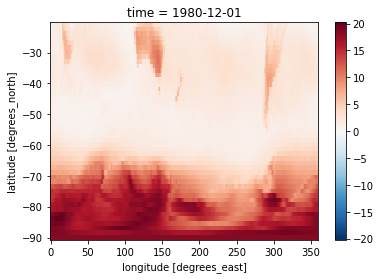

In [55]:
#Seasonal Mean of Field Variable, just an example here to make sure my method below is correct
t2m_shem_seas_mean_detrend_merra = t2m_shem_tmon_detrend_merra[2:(len(t2m_shem_tmon_detrend_merra['time'])-1)].resample(time='QS-MAR', closed='left'  ).mean(dim='time')
t2m_shem_seas_mean_detrend_merra[3].plot()

In [56]:
#Find SAM values for each of the 5 time periods and put in pd.DataFrame
#Then, select the upper and lower quartile values
#NEED TO SELECT ERA INDICE VALUES FROM 1980-2000 (NOT FULL RECORD)

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '12').dropna()),1)}
PSA2_djf_mean_merra = pd.DataFrame(data=d)
PSA2_djf_mean_merra = PSA2_djf_mean_merra.loc['1980-01-01':'1999-12-31'] #n=21 for djf
print(PSA2_djf_mean_merra)

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '03').dropna()),1)}
PSA2_mam_mean_merra = pd.DataFrame(data=d)
PSA2_mam_mean_merra = PSA2_mam_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA2_mam_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '06').dropna()),1)}
PSA2_jja_mean_merra = pd.DataFrame(data=d)
PSA2_jja_mean_merra = PSA2_jja_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA2_jja_mean_merra

d = {'PSA2': SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna(), 'indice': np.arange(0,len(SAM_PSAs_seas_mean_indices_merra.PSA2.where(SAM_PSAs_seas_mean_indices_merra.Seas_Index == '09').dropna()),1)}
PSA2_son_mean_merra = pd.DataFrame(data=d)
PSA2_son_mean_merra = PSA2_son_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA2_son_mean_merra

d = {'PSA2': SAM_PSAs_ann_mean_indices_merra.PSA2.dropna(), 'indice': np.arange(0, len(SAM_PSAs_ann_mean_indices_merra.PSA2.dropna()),1)}
PSA2_ann_mean_merra = pd.DataFrame(data=d)
PSA2_ann_mean_merra = PSA2_ann_mean_merra.loc['1980-01-01':'2000-12-31']
# PSA2_ann_mean_merra


#create list of indices representing the upper/lower quartiles of 'PSA2'
#Note, head is lower (sorted from low to high)
PSA2_djf_mean_lower_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_lower_merra
PSA2_djf_mean_upper_merra = PSA2_djf_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_djf_mean_merra.indice.size/4))).indice.tolist()
# PSA2_djf_mean_upper_merra

PSA2_mam_mean_lower_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_lower_merra
PSA2_mam_mean_upper_merra = PSA2_mam_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_mam_mean_merra.indice.size/4))).indice.tolist()
# PSA2_mam_mean_upper_merra

PSA2_jja_mean_lower_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_lower_merra
PSA2_jja_mean_upper_merra = PSA2_jja_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_jja_mean_merra.indice.size/4))).indice.tolist()
# PSA2_jja_mean_upper_merra

PSA2_son_mean_lower_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_lower_merra
PSA2_son_mean_upper_merra = PSA2_son_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_son_mean_merra.indice.size/4))).indice.tolist()
# PSA2_son_mean_upper_merra

PSA2_ann_mean_lower_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).head(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_lower_merra
PSA2_ann_mean_upper_merra = PSA2_ann_mean_merra.sort_values(by=['PSA2']).tail(n=(round(PSA2_ann_mean_merra.indice.size/4))).indice.tolist()
# PSA2_ann_mean_upper_merra

                PSA2  indice
time                        
1980-12-01 -0.021163       0
1981-12-01 -0.050230       1
1982-12-01  0.511646       2
1983-12-01  0.435018       3
1984-12-01  0.974320       4
1985-12-01  0.546180       5
1986-12-01  0.528692       6
1987-12-01 -0.243016       7
1988-12-01  0.070910       8
1989-12-01 -0.761147       9
1990-12-01  0.073529      10
1991-12-01  0.145724      11
1992-12-01  0.015492      12
1993-12-01 -0.225502      13
1994-12-01 -0.829897      14
1995-12-01  0.474770      15
1996-12-01  0.358739      16
1997-12-01 -0.958949      17
1998-12-01 -0.031628      18
1999-12-01 -0.396307      19


In [57]:
PSA2_djf_mean_lower_merra

[17, 14, 9, 19, 7]

In [58]:
PSA2_djf_mean_upper_merra

[15, 2, 6, 5, 4]

In [59]:
PSA2_mam_mean_lower_merra

[18, 12, 8, 14, 3]

In [60]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=21, so no need to crop the time series)
djf_t2m_w_upper_PSA2_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_djf_mean_upper_merra)
djf_t2m_w_lower_PSA2_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_djf_mean_lower_merra)
# djf_t2m_w_upper_PSA2_detrend_merra
# djf_t2m_w_lower_PSA2_detrend_merra

#mam
mam_t2m_w_upper_PSA2_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_mam_mean_upper_merra)
mam_t2m_w_lower_PSA2_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_mam_mean_lower_merra)
# mam_t2m_w_upper_PSA2_detrend_merra
# mam_t2m_w_lower_PSA2_detrend_merra

#jja
jja_t2m_w_upper_PSA2_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_jja_mean_upper_merra)
jja_t2m_w_lower_PSA2_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_jja_mean_lower_merra)
# jja_t2m_w_upper_PSA2_detrend_merra
# jja_t2m_w_lower_PSA2_detrend_merra

#son
son_t2m_w_upper_PSA2_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_son_mean_upper_merra)
son_t2m_w_lower_PSA2_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = PSA2_son_mean_lower_merra)
son_t2m_w_upper_PSA2_detrend_merra
# son_t2m_w_lower_PSA2_detrend_merra

#ann mean
ann_mean_t2m_w_upper_PSA2_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA2_ann_mean_upper_merra)
ann_mean_t2m_w_lower_PSA2_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = PSA2_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_PSA2_detrend_merra
# ann_mean_t2m_w_lower_PSA2_detrend_merra


In [61]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA2_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_PSA2_detrend_merra
djf_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[PSA2_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_PSA2_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA2_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_PSA2_detrend_merra
mam_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[PSA2_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_PSA2_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA2_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_PSA2_detrend_merra
jja_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[PSA2_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_PSA2_detrend_merra

#son
son_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA2_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_PSA2_detrend_merra
son_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[PSA2_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_PSA2_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA2_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra
ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[PSA2_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra



In [62]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, df = 5+5-2 = 8 ; +- 2.31
#Seasonal, df=6+6-2 = 10 ; critical value = +- 2.31
#ann mean, df =6+6-2 = 10 ; critical value = +- 2.31

djf_t2m_change_due_to_PSA2_ttest_stats_merra, djf_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    djf_t2m_w_upper_PSA2_detrend_merra, djf_t2m_w_lower_PSA2_detrend_merra, axis=0)

mam_t2m_change_due_to_PSA2_ttest_stats_merra, mam_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    mam_t2m_w_upper_PSA2_detrend_merra, mam_t2m_w_lower_PSA2_detrend_merra, axis=0)

jja_t2m_change_due_to_PSA2_ttest_stats_merra, jja_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    jja_t2m_w_upper_PSA2_detrend_merra, jja_t2m_w_lower_PSA2_detrend_merra, axis=0)

son_t2m_change_due_to_PSA2_ttest_stats_merra, son_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    son_t2m_w_upper_PSA2_detrend_merra, son_t2m_w_lower_PSA2_detrend_merra, axis=0)

ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra, ann_mean_t2m_change_due_to_PSA2_ttest_pvals_merra = ttest_ind(
    ann_mean_t2m_w_upper_PSA2_detrend_merra, ann_mean_t2m_w_lower_PSA2_detrend_merra, axis=0)

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-6.612765786603927 -5.000300171107801


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:99: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.370836804601254 -7.961166496785813


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:178: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.843806323141758 -10.291164537237638


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:257: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-7.840470737266605 -8.49979387276601


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:336: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.602206980595997 -5.986978873901284


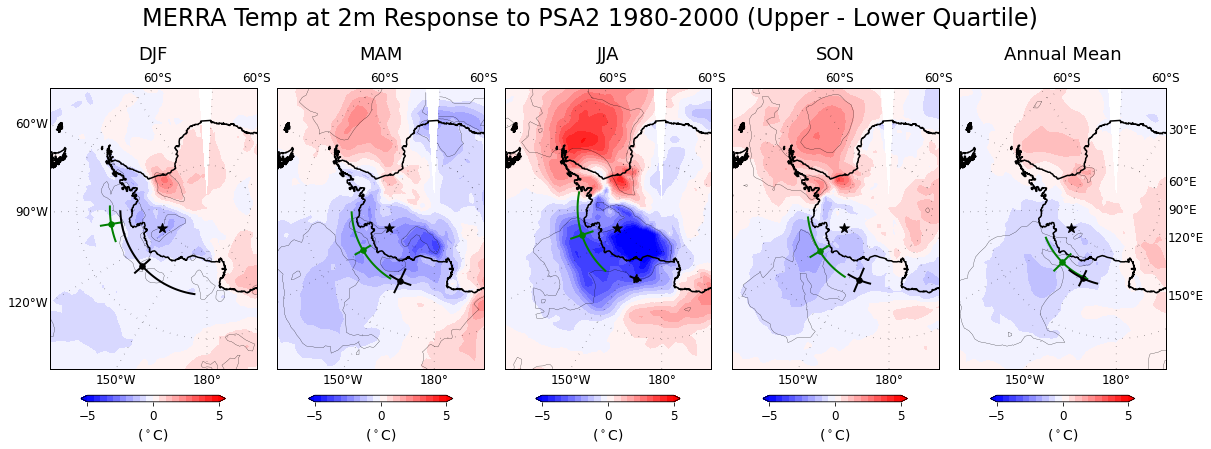

In [63]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA Temp at 2m Response to PSA2 1980-2000 (Upper - Lower Quartile)', fontsize=24, y=1.05)

# setup Lambert Conformal basemap.

lon, lat = np.meshgrid(MERRA_DATA.coords['lon'].values,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour = [-2.31,2.31] #good for other seasons and annual mean
levels_contour_djf = [-2.31, 2.31] #good for djf

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((djf_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (djf_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_change_due_to_PSA2_ttest_stats_merra,levels_contour_djf,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(mam_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((mam_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (mam_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(mam_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_change_due_to_PSA2_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(jja_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((jja_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (jja_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(jja_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_change_due_to_PSA2_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(son_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((son_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (son_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(son_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_change_due_to_PSA2_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


#Annual Mean
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
#CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)).where((ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra >= levels_contour[1]) | (ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra < levels_contour[0]) ),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
CS = m.contourf(x,y,(ann_mean_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_merra.mean(axis=0)),levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra,levels_contour,linewidths=0.25,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.vals.mean())


# plt.savefig(FIG_PATH+'/Figure_MERRA_t2m_Field_vs_PSA2_Quartiles_04May2020.ps',bbox_inches='tight', pad_inches=0.05)

plt.show()

### Select quartile difference values that are significant (bounded between [-2.31,2.31] for djf and bounded between [-2.31,2.31] for all other seasons and annual mean)

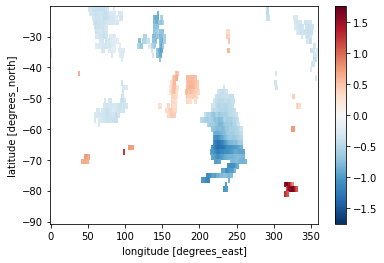

In [64]:
djf_t2m_quart_diff_due_to_PSA2_merra = (djf_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-djf_t2m_w_lower_PSA2_detrend_merra.mean(axis=0))
djf_t2m_quart_diff_due_to_PSA2_merra_bounded = djf_t2m_quart_diff_due_to_PSA2_merra.where((djf_t2m_change_due_to_PSA2_ttest_stats_merra <= -2.31) | (djf_t2m_change_due_to_PSA2_ttest_stats_merra >= 2.31))
mam_t2m_quart_diff_due_to_PSA2_merra = (mam_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-mam_t2m_w_lower_PSA2_detrend_merra.mean(axis=0))
mam_t2m_quart_diff_due_to_PSA2_merra_bounded = mam_t2m_quart_diff_due_to_PSA2_merra.where((mam_t2m_change_due_to_PSA2_ttest_stats_merra <= -2.31) | (mam_t2m_change_due_to_PSA2_ttest_stats_merra >= 2.31))
jja_t2m_quart_diff_due_to_PSA2_merra = (jja_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-jja_t2m_w_lower_PSA2_detrend_merra.mean(axis=0))
jja_t2m_quart_diff_due_to_PSA2_merra_bounded = jja_t2m_quart_diff_due_to_PSA2_merra.where((jja_t2m_change_due_to_PSA2_ttest_stats_merra <= -2.31) | (jja_t2m_change_due_to_PSA2_ttest_stats_merra >= 2.31))
son_t2m_quart_diff_due_to_PSA2_merra = (son_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-son_t2m_w_lower_PSA2_detrend_merra.mean(axis=0))
son_t2m_quart_diff_due_to_PSA2_merra_bounded = son_t2m_quart_diff_due_to_PSA2_merra.where((son_t2m_change_due_to_PSA2_ttest_stats_merra <= -2.31) | (son_t2m_change_due_to_PSA2_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_PSA2_merra = (ann_mean_t2m_w_upper_PSA2_detrend_merra.mean(axis=0)-ann_mean_t2m_w_lower_PSA2_detrend_merra.mean(axis=0))
ann_mean_t2m_quart_diff_due_to_PSA2_merra_bounded = ann_mean_t2m_quart_diff_due_to_PSA2_merra.where((ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra <= -2.31) | (ann_mean_t2m_change_due_to_PSA2_ttest_stats_merra >= 2.31))
ann_mean_t2m_quart_diff_due_to_PSA2_merra_bounded.plot()

## PART 3.3: Finalize Figure - For PSA2, T2M, and WDC d18O
### 1980-2000


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


983.080078125 981.2168334960937


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:111: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


978.460546875 977.9118530273438


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:190: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


977.5357177734375 977.33017578125


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:270: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


973.8413696289062 974.8874877929687
980.2265747070312 978.8170532226562
-1.367
-1.854
-3.307
-0.234
-0.585


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:350: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


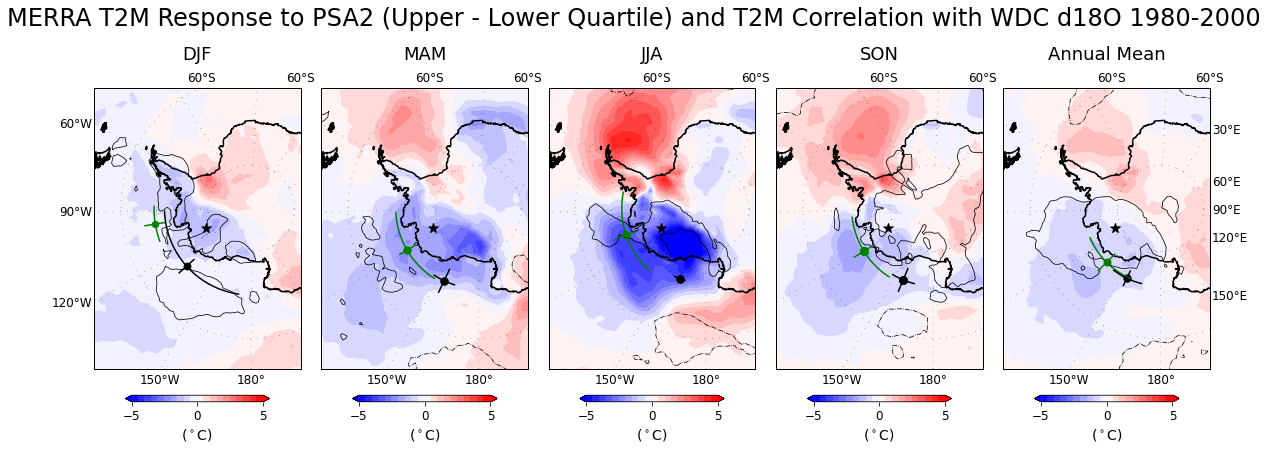

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA T2M Response to PSA2 (Upper - Lower Quartile) and T2M Correlation with WDC d18O 1980-2000', fontsize=24, y=1.05)

#Remove Pizza slice in variables
djf_t2m_quart_diff_due_to_PSA2_merra_fin, lons = add_cyclic_point(djf_t2m_quart_diff_due_to_PSA2_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_quart_diff_due_to_PSA2_merra_fin, lons = add_cyclic_point(mam_t2m_quart_diff_due_to_PSA2_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_quart_diff_due_to_PSA2_merra_fin, lons = add_cyclic_point(jja_t2m_quart_diff_due_to_PSA2_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_quart_diff_due_to_PSA2_merra_fin, lons = add_cyclic_point(son_t2m_quart_diff_due_to_PSA2_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_quart_diff_due_to_PSA2_merra_fin, lons = add_cyclic_point(ann_mean_t2m_quart_diff_due_to_PSA2_merra.values, MERRA_DATA.coords['lon'].values, axis=-1)

djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)
ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin, lons = add_cyclic_point(ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra.pearsons.values, MERRA_DATA.coords['lon'].values, axis=-1)

# setup Lambert Conformal basemap.
lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-5,5.5,.5)
levels_contour_djf = [-.433,.433] #good for other seasons and annual mean
levels_contour = [-.423,.423] #good for other seasons and annual mean

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'dashdot'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,djf_t2m_quart_diff_due_to_PSA2_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,djf_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour_djf,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=60) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean(),djf_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())


#MAM
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,mam_t2m_quart_diff_due_to_PSA2_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,mam_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('MAM',y=1.08,fontsize=18)
print(mam_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean(),mam_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())
                
     
#JJA
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,jja_t2m_quart_diff_due_to_PSA2_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,jja_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean(),jja_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())        
        
        
        
 #SON
plt.subplot(1, 5, 4)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,son_t2m_quart_diff_due_to_PSA2_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,son_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,son_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('SON',y=1.08,fontsize=18)
print(son_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean(),son_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())


 
#Annual
plt.subplot(1, 5, 5)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,ann_mean_t2m_quart_diff_due_to_PSA2_merra_fin,levels,cmap=plt.cm.get_cmap('bwr'),extend='both')
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label('($^\circ$C)',size=14)
cbar.set_ticks([-5, 0, 5])
cbar.ax.tick_params(labelsize=12)
plt.clim([-5,5])
CS2 = m.contour(x,y,ann_mean_t2m_anoms_and_WDC_d18O_1980_2000_corr_coef_merra_fin,levels_contour,linewidths=0.75,colors='k')

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='green', marker='o', s=((990-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean())*3+20))
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
           )
# plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
plt.scatter(xpt, ypt, c='k', marker='o', s=((990-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())*3+20))

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=1.5)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=1.5)

#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_PSA2_detrend_merra.abs_vals.mean(),ann_mean_Rel_CP_indices_w_lower_PSA2_detrend_merra.abs_vals.mean())    
    
# plt.savefig(FIG_PATH+'/Figure_MERRA_Section_2_Figure_T2M_WDC_and_PSA2_1980_2000_04May2020.ps',bbox_inches='tight', pad_inches=0.02)    

#print field variable quart diff at WDC location
print(np.round_(djf_t2m_quart_diff_due_to_PSA2_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(mam_t2m_quart_diff_due_to_PSA2_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(jja_t2m_quart_diff_due_to_PSA2_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(son_t2m_quart_diff_due_to_PSA2_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))
print(np.round_(ann_mean_t2m_quart_diff_due_to_PSA2_merra.sel(lat=-78.63, lon=247.5, method='nearest').values,decimals=3))


plt.show()

In [66]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_upper_merra]
# djf_Rel_CP_indices_w_upper_SAM_detrend_merra
djf_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[SAM_djf_mean_lower_merra]
# djf_Rel_CP_indices_w_lower_SAM_detrend_merra

#mam
mam_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_upper_merra]
# mam_Rel_CP_indices_w_upper_SAM_detrend_merra
mam_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_mam_mean_indices_raw_merra.iloc[SAM_mam_mean_lower_merra]
# mam_Rel_CP_indices_w_lower_SAM_detrend_merra

#jja
jja_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_upper_merra]
# jja_Rel_CP_indices_w_upper_SAM_detrend_merra
jja_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[SAM_jja_mean_lower_merra]
# jja_Rel_CP_indices_w_lower_SAM_detrend_merra

#son
son_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_upper_merra]
# son_Rel_CP_indices_w_upper_SAM_detrend_merra
son_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_son_mean_indices_raw_merra.iloc[SAM_son_mean_lower_merra]
# son_Rel_CP_indices_w_lower_SAM_detrend_merra

#annual mean
ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_upper_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra
ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[SAM_ann_mean_lower_merra]
# ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra



In [67]:
#Select the times of the field variable dependent upon quartile and the indice 

#DJF, (both datasets already at s=21, so no need to crop the time series)
djf_t2m_w_upper_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_upper_merra)
djf_t2m_w_lower_SAM_detrend_merra = djf_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_djf_mean_lower_merra)
# djf_t2m_w_upper_SAM_detrend_merra
# djf_t2m_w_lower_SAM_detrend_merra

#mam
mam_t2m_w_upper_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_upper_merra)
mam_t2m_w_lower_SAM_detrend_merra = mam_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_mam_mean_lower_merra)
# mam_t2m_w_upper_SAM_detrend_merra
# mam_t2m_w_lower_SAM_detrend_merra

#jja
jja_t2m_w_upper_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_upper_merra)
jja_t2m_w_lower_SAM_detrend_merra = jja_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_jja_mean_lower_merra)
# jja_t2m_w_upper_SAM_detrend_merra
# jja_t2m_w_lower_SAM_detrend_merra

#son
son_t2m_w_upper_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_upper_merra)
son_t2m_w_lower_SAM_detrend_merra = son_t2m_shem_seas_mean_detrend_merra.isel(time = SAM_son_mean_lower_merra)
son_t2m_w_upper_SAM_detrend_merra
# son_t2m_w_lower_SAM_detrend_merra

#ann mean
ann_mean_t2m_w_upper_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_upper_merra)
ann_mean_t2m_w_lower_SAM_detrend_merra = t2m_shem_ann_mean_detrend_merra.isel(time = SAM_ann_mean_lower_merra)
# ann_mean_t2m_w_upper_SAM_detrend_merra
# ann_mean_t2m_w_lower_SAM_detrend_merra

In [68]:
# df_WDC_djf_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '12').dropna()
# df_WDC_mam_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '03').dropna()
# df_WDC_jja_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '06').dropna()
# df_WDC_son_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.where(df_WDC_seas_1982_2002_detrend.Seas_Index == '09').dropna()


# df_WDC_djf_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '12').dropna()
# df_WDC_mam_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '03').dropna()
# df_WDC_jja_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '06').dropna()
# df_WDC_son_1982_2002_detrend_anoms = df_WDC_seas_1982_2002_detrend_anoms.where(df_WDC_seas_1982_2002_detrend_anoms.Seas_Index == '09').dropna()

In [69]:
djf_t2m_w_upper_SAM_detrend_merra

<xarray.DataArray (time: 5, lat: 47, lon: 240)>
array([[[ 1.7181772,  1.8069891,  1.8638903, ...,  1.5551987,
          1.6167068,  1.6678289],
        [ 1.9310932,  1.9646282,  1.9623528, ...,  1.8705889,
          1.8837376,  1.9348965],
        [ 2.1600075,  2.1854656,  2.2032897, ...,  2.1732547,
          2.1438625,  2.1324222],
        ...,
        [16.442177 , 16.46784  , 16.48887  , ..., 16.344173 ,
         16.379177 , 16.41222  ],
        [16.578712 , 16.563375 , 16.547333 , ..., 16.62063  ,
         16.606913 , 16.592947 ],
        [16.16963  , 16.16963  , 16.16963  , ..., 16.16963  ,
         16.16963  , 16.16963  ]],

       [[ 1.2131754,  1.2343744,  1.2656441, ...,  1.1958472,
          1.2449526,  1.2142359],
        [ 1.30623  ,  1.3334064,  1.2835712, ...,  1.3446573,
          1.3680083,  1.3550593],
        [ 1.498855 ,  1.4822006,  1.4346033, ...,  1.4557031,
          1.4655291,  1.4914175],
...
        [18.488054 , 18.513931 , 18.53513  , ..., 18.389982 ,
         18.4249   , 18.458199 ],
        [18.518633 , 18.509533 , 18.500494 , ..., 18.544806 ,
         18.536375 , 18.527777 ],
        [17.910025 , 17.910025 , 17.910025 , ..., 17.910025 ,
         17.910025 , 17.910025 ]],

       [[ 1.434606 ,  1.5381069,  1.6462618, ...,  1.166329 ,
          1.2124487,  1.3069948],
        [ 1.4503778,  1.5289516,  1.6378301, ...,  1.3518562,
          1.2552605,  1.324461 ],
        [ 1.4187514,  1.4614868,  1.5514914, ...,  1.4203434,
          1.3452536,  1.3287779],
        ...,
        [15.883255 , 15.883189 , 15.878693 , ..., 15.862228 ,
         15.871846 , 15.879077 ],
        [15.859399 , 15.839672 , 15.82199  , ..., 15.922755 ,
         15.902034 , 15.8808775],
        [15.233087 , 15.233087 , 15.233087 , ..., 15.233087 ,
         15.233087 , 15.233087 ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1994-12-01 1993-12-01 ... 1999-12-01
  * lat      (lat) float64 -21.0 -22.5 -24.0 -25.5 ... -85.5 -87.0 -88.5 -90.0
  * lon      (lon) float64 0.0 1.5 3.0 4.5 6.0 ... 352.5 354.0 355.5 357.0 358.5

In [70]:
# df_WDC_djf_1982_2002_detrend.isel(time = SAM_mam_mean_upper_merra)

In [71]:
SAM_mam_mean_upper_merra

[20, 18, 9, 19, 2]

In [72]:
df_WDC_mam_1982_2002_detrend

,d18O_Recon_March,Seas_Index
time,,
1982-03-01,2.297129,03
1983-03-01,0.132106,03
1984-03-01,0.369435,03
1985-03-01,0.568483,03
1986-03-01,-0.806345,03
1987-03-01,1.348408,03
1988-03-01,-1.802110,03
1989-03-01,-0.918573,03
1990-03-01,1.458651,03


In [73]:
df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_upper_merra]

,d18O_Recon_March,Seas_Index
time,,
2002-03-01,0.736888,03
2000-03-01,2.030826,03
1991-03-01,1.590100,03
2001-03-01,0.237109,03
1984-03-01,0.369435,03


In [74]:
df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_upper_merra].mean(0)[0]

0.9928715001432321

In [75]:
print('d18O change at WDC wrt SAM')
WDC_d18O_change_djf_1982_2002_wrt_SAM = df_WDC_djf_1982_2002_detrend.iloc[SAM_djf_mean_upper_merra].mean(0)[0] - df_WDC_djf_1982_2002_detrend.iloc[SAM_djf_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_djf_1982_2002_wrt_SAM)
WDC_d18O_change_mam_1982_2002_wrt_SAM = df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_upper_merra].mean(0)[0] - df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_mam_1982_2002_wrt_SAM)
WDC_d18O_change_jja_1982_2002_wrt_SAM = df_WDC_jja_1982_2002_detrend.iloc[SAM_jja_mean_upper_merra].mean(0)[0] - df_WDC_jja_1982_2002_detrend.iloc[SAM_jja_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_jja_1982_2002_wrt_SAM)
WDC_d18O_change_son_1982_2002_wrt_SAM = df_WDC_son_1982_2002_detrend.iloc[SAM_son_mean_upper_merra].mean(0)[0] - df_WDC_son_1982_2002_detrend.iloc[SAM_son_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_son_1982_2002_wrt_SAM)
df_WDC_ann_mean_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.resample('AS', closed='left').mean()
WDC_d18O_change_ann_mean_1982_2002_wrt_SAM = df_WDC_ann_mean_1982_2002_detrend.iloc[SAM_ann_mean_upper_merra].mean(0)[0] - df_WDC_ann_mean_1982_2002_detrend.iloc[SAM_ann_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_ann_mean_1982_2002_wrt_SAM)

d18O change at WDC wrt SAM
-1.1410460283221762
-0.05873639938912201
-0.150763133068339
-2.337945908269178
-0.9692508572622042


In [76]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, df = 5+5-2 = 8 ; +- 2.31
#Seasonal, df=6+6-2 = 10 ; critical value = +- 2.31
#ann mean, df =6+6-2 = 10 ; critical value = +- 2.31
print('SAM p values')
djf_WDC_d18O_change_due_to_SAM_ttest_stats, djf_WDC_d18O_change_due_to_SAM_ttest_pvals = ttest_ind(
    df_WDC_djf_1982_2002_detrend.iloc[SAM_djf_mean_upper_merra]['d18O_Recon_March'], df_WDC_djf_1982_2002_detrend.iloc[SAM_djf_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(djf_WDC_d18O_change_due_to_SAM_ttest_pvals)
mam_WDC_d18O_change_due_to_SAM_ttest_stats, mam_WDC_d18O_change_due_to_SAM_ttest_pvals = ttest_ind(
    df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_upper_merra]['d18O_Recon_March'], df_WDC_mam_1982_2002_detrend.iloc[SAM_mam_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(mam_WDC_d18O_change_due_to_SAM_ttest_pvals)
jja_WDC_d18O_change_due_to_SAM_ttest_stats, jja_WDC_d18O_change_due_to_SAM_ttest_pvals = ttest_ind(
    df_WDC_jja_1982_2002_detrend.iloc[SAM_jja_mean_upper_merra]['d18O_Recon_March'], df_WDC_jja_1982_2002_detrend.iloc[SAM_jja_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(jja_WDC_d18O_change_due_to_SAM_ttest_pvals)
son_WDC_d18O_change_due_to_SAM_ttest_stats, son_WDC_d18O_change_due_to_SAM_ttest_pvals = ttest_ind(
    df_WDC_son_1982_2002_detrend.iloc[SAM_son_mean_upper_merra]['d18O_Recon_March'], df_WDC_son_1982_2002_detrend.iloc[SAM_son_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(son_WDC_d18O_change_due_to_SAM_ttest_pvals)
ann_mean_WDC_d18O_change_due_to_SAM_ttest_stats, ann_mean_WDC_d18O_change_due_to_SAM_ttest_pvals = ttest_ind(
    df_WDC_ann_mean_1982_2002_detrend.iloc[SAM_ann_mean_upper_merra]['d18O_Recon_March'], df_WDC_ann_mean_1982_2002_detrend.iloc[SAM_ann_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(ann_mean_WDC_d18O_change_due_to_SAM_ttest_pvals)

SAM p values
0.3290988746814051
0.950101954188419
0.8674520892974037
0.01650036189515508
0.13830218951537387


In [77]:
print('d18O change at WDC wrt PSA1')
WDC_d18O_change_djf_1982_2002_wrt_PSA1 = df_WDC_djf_1982_2002_detrend.iloc[PSA1_djf_mean_upper_merra].mean(0)[0] - df_WDC_djf_1982_2002_detrend.iloc[PSA1_djf_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_djf_1982_2002_wrt_PSA1)
WDC_d18O_change_mam_1982_2002_wrt_PSA1 = df_WDC_mam_1982_2002_detrend.iloc[PSA1_mam_mean_upper_merra].mean(0)[0] - df_WDC_mam_1982_2002_detrend.iloc[PSA1_mam_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_mam_1982_2002_wrt_PSA1)
WDC_d18O_change_jja_1982_2002_wrt_PSA1 = df_WDC_jja_1982_2002_detrend.iloc[PSA1_jja_mean_upper_merra].mean(0)[0] - df_WDC_jja_1982_2002_detrend.iloc[PSA1_jja_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_jja_1982_2002_wrt_PSA1)
WDC_d18O_change_son_1982_2002_wrt_PSA1 = df_WDC_son_1982_2002_detrend.iloc[PSA1_son_mean_upper_merra].mean(0)[0] - df_WDC_son_1982_2002_detrend.iloc[PSA1_son_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_son_1982_2002_wrt_PSA1)
df_WDC_ann_mean_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.resample('AS', closed='left').mean()
WDC_d18O_change_ann_mean_1982_2002_wrt_PSA1 = df_WDC_ann_mean_1982_2002_detrend.iloc[PSA1_ann_mean_upper_merra].mean(0)[0] - df_WDC_ann_mean_1982_2002_detrend.iloc[PSA1_ann_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_ann_mean_1982_2002_wrt_PSA1)

d18O change at WDC wrt PSA1
0.5426742639386322
0.09738335800139553
-1.6389752778075317
-0.5245965108758721
-0.6466433141722452


In [78]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, df = 5+5-2 = 8 ; +- 2.31
#Seasonal, df=6+6-2 = 10 ; critical value = +- 2.31
#ann mean, df =6+6-2 = 10 ; critical value = +- 2.31
print('PSA1 p values')
djf_WDC_d18O_change_due_to_PSA1_ttest_stats, djf_WDC_d18O_change_due_to_PSA1_ttest_pvals = ttest_ind(
    df_WDC_djf_1982_2002_detrend.iloc[PSA1_djf_mean_upper_merra]['d18O_Recon_March'], df_WDC_djf_1982_2002_detrend.iloc[PSA1_djf_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(djf_WDC_d18O_change_due_to_PSA1_ttest_pvals)
mam_WDC_d18O_change_due_to_PSA1_ttest_stats, mam_WDC_d18O_change_due_to_PSA1_ttest_pvals = ttest_ind(
    df_WDC_mam_1982_2002_detrend.iloc[PSA1_mam_mean_upper_merra]['d18O_Recon_March'], df_WDC_mam_1982_2002_detrend.iloc[PSA1_mam_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(mam_WDC_d18O_change_due_to_PSA1_ttest_pvals)
jja_WDC_d18O_change_due_to_PSA1_ttest_stats, jja_WDC_d18O_change_due_to_PSA1_ttest_pvals = ttest_ind(
    df_WDC_jja_1982_2002_detrend.iloc[PSA1_jja_mean_upper_merra]['d18O_Recon_March'], df_WDC_jja_1982_2002_detrend.iloc[PSA1_jja_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(jja_WDC_d18O_change_due_to_PSA1_ttest_pvals)
son_WDC_d18O_change_due_to_PSA1_ttest_stats, son_WDC_d18O_change_due_to_PSA1_ttest_pvals = ttest_ind(
    df_WDC_son_1982_2002_detrend.iloc[PSA1_son_mean_upper_merra]['d18O_Recon_March'], df_WDC_son_1982_2002_detrend.iloc[PSA1_son_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(son_WDC_d18O_change_due_to_PSA1_ttest_pvals)
ann_mean_WDC_d18O_change_due_to_PSA1_ttest_stats, ann_mean_WDC_d18O_change_due_to_PSA1_ttest_pvals = ttest_ind(
    df_WDC_ann_mean_1982_2002_detrend.iloc[PSA1_ann_mean_upper_merra]['d18O_Recon_March'], df_WDC_ann_mean_1982_2002_detrend.iloc[PSA1_ann_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(ann_mean_WDC_d18O_change_due_to_PSA1_ttest_pvals)

PSA1 p values
0.6753831894700631
0.9217767861560942
0.06362270017378821
0.5855918412798689
0.44151097249086757


In [79]:
print('d18O change at WDC wrt PSA2')
WDC_d18O_change_djf_1982_2002_wrt_PSA2 = df_WDC_djf_1982_2002_detrend.iloc[PSA2_djf_mean_upper_merra].mean(0)[0] - df_WDC_djf_1982_2002_detrend.iloc[PSA2_djf_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_djf_1982_2002_wrt_PSA2)
WDC_d18O_change_mam_1982_2002_wrt_PSA2 = df_WDC_mam_1982_2002_detrend.iloc[PSA2_mam_mean_upper_merra].mean(0)[0] - df_WDC_mam_1982_2002_detrend.iloc[PSA2_mam_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_mam_1982_2002_wrt_PSA2)
WDC_d18O_change_jja_1982_2002_wrt_PSA2 = df_WDC_jja_1982_2002_detrend.iloc[PSA2_jja_mean_upper_merra].mean(0)[0] - df_WDC_jja_1982_2002_detrend.iloc[PSA2_jja_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_jja_1982_2002_wrt_PSA2)
WDC_d18O_change_son_1982_2002_wrt_PSA2 = df_WDC_son_1982_2002_detrend.iloc[PSA2_son_mean_upper_merra].mean(0)[0] - df_WDC_son_1982_2002_detrend.iloc[PSA2_son_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_son_1982_2002_wrt_PSA2)
df_WDC_ann_mean_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.resample('AS', closed='left').mean()
WDC_d18O_change_ann_mean_1982_2002_wrt_PSA2 = df_WDC_ann_mean_1982_2002_detrend.iloc[PSA2_ann_mean_upper_merra].mean(0)[0] - df_WDC_ann_mean_1982_2002_detrend.iloc[PSA2_ann_mean_lower_merra].mean(0)[0]
print(WDC_d18O_change_ann_mean_1982_2002_wrt_PSA2)

d18O change at WDC wrt PSA2
-1.3895371252761506
-0.7377898398688969
-1.7973621110013964
0.6822396659972126
-1.457462416609483


In [80]:
#Calculate significance for the change in mean of the field variable for Positive-Negative
#critical value for t-test at 95%:
#DJF, df = 5+5-2 = 8 ; +- 2.31
#Seasonal, df=6+6-2 = 10 ; critical value = +- 2.31
#ann mean, df =6+6-2 = 10 ; critical value = +- 2.31
print('PSA2 p values')
djf_WDC_d18O_change_due_to_PSA2_ttest_stats, djf_WDC_d18O_change_due_to_PSA2_ttest_pvals = ttest_ind(
    df_WDC_djf_1982_2002_detrend.iloc[PSA2_djf_mean_upper_merra]['d18O_Recon_March'], df_WDC_djf_1982_2002_detrend.iloc[PSA2_djf_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(djf_WDC_d18O_change_due_to_PSA2_ttest_pvals)
mam_WDC_d18O_change_due_to_PSA2_ttest_stats, mam_WDC_d18O_change_due_to_PSA2_ttest_pvals = ttest_ind(
    df_WDC_mam_1982_2002_detrend.iloc[PSA2_mam_mean_upper_merra]['d18O_Recon_March'], df_WDC_mam_1982_2002_detrend.iloc[PSA2_mam_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(mam_WDC_d18O_change_due_to_PSA2_ttest_pvals)
jja_WDC_d18O_change_due_to_PSA2_ttest_stats, jja_WDC_d18O_change_due_to_PSA2_ttest_pvals = ttest_ind(
    df_WDC_jja_1982_2002_detrend.iloc[PSA2_jja_mean_upper_merra]['d18O_Recon_March'], df_WDC_jja_1982_2002_detrend.iloc[PSA2_jja_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(jja_WDC_d18O_change_due_to_PSA2_ttest_pvals)
son_WDC_d18O_change_due_to_PSA2_ttest_stats, son_WDC_d18O_change_due_to_PSA2_ttest_pvals = ttest_ind(
    df_WDC_son_1982_2002_detrend.iloc[PSA2_son_mean_upper_merra]['d18O_Recon_March'], df_WDC_son_1982_2002_detrend.iloc[PSA2_son_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(son_WDC_d18O_change_due_to_PSA2_ttest_pvals)
ann_mean_WDC_d18O_change_due_to_PSA2_ttest_stats, ann_mean_WDC_d18O_change_due_to_PSA2_ttest_pvals = ttest_ind(
    df_WDC_ann_mean_1982_2002_detrend.iloc[PSA2_ann_mean_upper_merra]['d18O_Recon_March'], df_WDC_ann_mean_1982_2002_detrend.iloc[PSA2_ann_mean_lower_merra]['d18O_Recon_March'], axis=0)
print(ann_mean_WDC_d18O_change_due_to_PSA2_ttest_pvals)

PSA2 p values
0.11428581359066008
0.4907295657236974
0.07354820355106528
0.4969525837364601
0.05433839945036931


# DO REGRESSION ANALYSIS
## For Reviews

### We want a seasonal and annual time series of WDC d18O

In [81]:
# df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values #198212-200112, 20
# df_WDC_jja_1982_2002_detrend.d18O_Recon_March.values #198206-200206,21

df_WDC_ann_mean_1982_2002_detrend = df_WDC_seas_1982_2002_detrend.resample('AS', closed='left').mean()
# df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March.values #198201-200201, 21



### We want a map of T2M for each of the seasons and annual mean 

In [82]:

# djf_t2m_shem_seas_mean_detrend_merra #198012-199912, 20
# jja_t2m_shem_seas_mean_detrend_merra #198006-200006, 21
ann_mean_t2m_shem_seas_mean_detrend_merra = t2m_shem_ann_mean_detrend_merra  #198001 - 200001, 21



### Regression Calculation

#### Regress WDC onto T2M

In [83]:
#Note, for the time series input, must select the column name and .values

##### CESM pseudoWDC
###djf
slope_wdc_djf, intercept_wdc_djf, r_value_wdc_djf, p_value_wdc_djf, std_err_wdc_djf = xr.apply_ufunc(stats.linregress,
                                                                                 df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 djf_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_wdc_djf = r_value_wdc_djf**2

###jja
slope_wdc_jja, intercept_wdc_jja, r_value_wdc_jja, p_value_wdc_jja, std_err_wdc_jja = xr.apply_ufunc(stats.linregress,
                                                                                 df_WDC_jja_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 jja_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_wdc_jja = r_value_wdc_jja**2

###ann_mean
slope_wdc_ann_mean, intercept_wdc_ann_mean, r_value_wdc_ann_mean, p_value_wdc_ann_mean, std_err_wdc_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 ann_mean_t2m_shem_seas_mean_detrend_merra,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_wdc_ann_mean = r_value_wdc_ann_mean**2

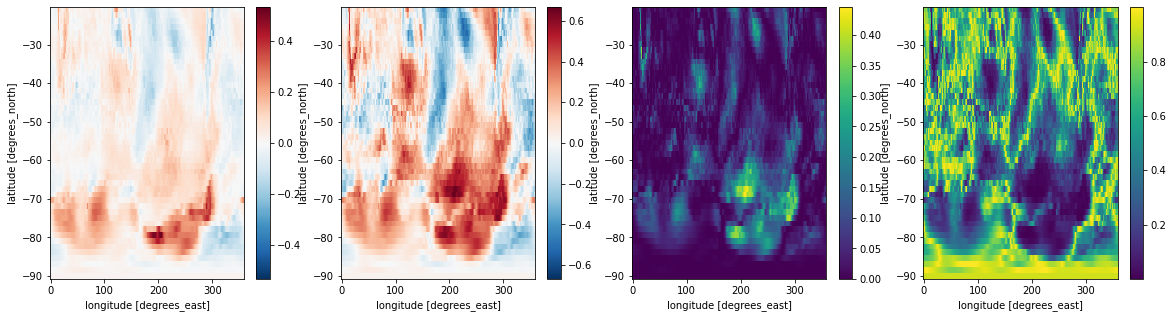

In [84]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_wdc_djf*r_value_wdc_djf #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_wdc_djf.plot()

ax = plt.subplot(1,4,2)
r_value_wdc_djf.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_wdc_djf.plot()

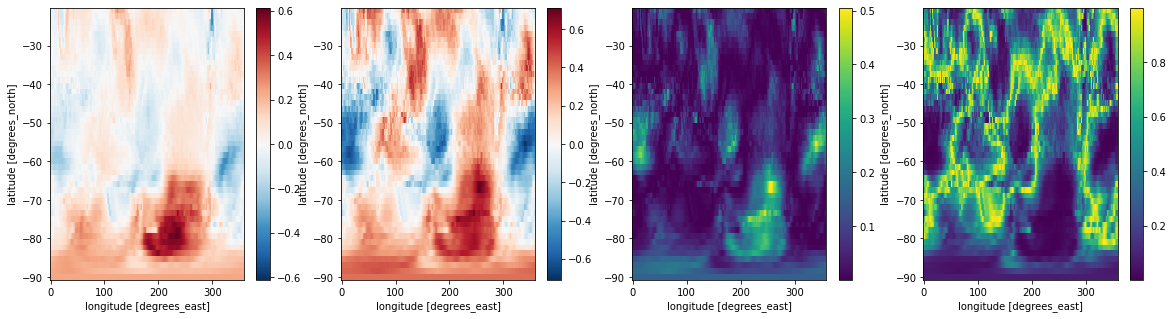

In [85]:
# use xarray to make a tester plot of the r values and p values to see the range to be sure looks about right 
fig = plt.figure(figsize=(20,5))

rsquared = r_value_wdc_ann_mean*r_value_wdc_ann_mean #multiplying rval * rval to get rsquared

ax = plt.subplot(1,4,1)
slope_wdc_ann_mean.plot()

ax = plt.subplot(1,4,2)
r_value_wdc_ann_mean.plot()

ax = plt.subplot(1,4,3)
rsquared.plot()

ax = plt.subplot(1,4,4)
p_value_wdc_ann_mean.plot()

#### Now make a matrix of numbers and NaNs where the rsquared and pvals meet certain criteria

In [86]:
# threshold_rsquared = 0.5
# threshold_pval = 0.01

# stipple = rsquared.where(rsquared > threshold_rsquared) #note that the xarray where command keeps all values meeting criteria, others nan/missing
# stipple = stipple.where(p_value_annual < threshold_pval) #now find everywhere pvals meet threshold (AKA significant)
# stipple = stipple.where(xr.ufuncs.logical_not(stipple > 0) , 1) #OK, now we should have rsquared vals where significant, missing/zero where not, so let's replace rsquared with 1 so we have missing/zero and 1 values

# stipple

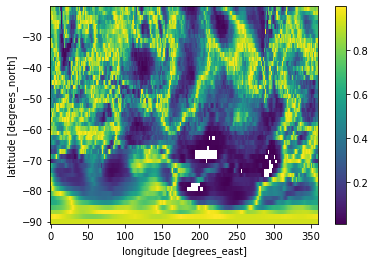

In [87]:
p_value_wdc_djf.where(p_value_wdc_djf >= 0.01).plot()

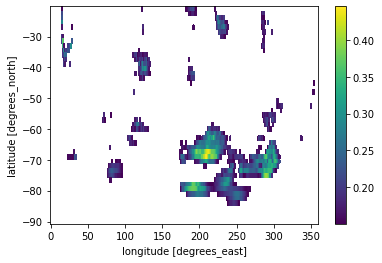

In [88]:
r2_value_wdc_djf.where(r2_value_wdc_djf >= 0.15).plot()

In [89]:
######  Ideas For Statistical Significance of the Regression Slope   ######

pval_threshold = 0.05
r2_threshold   = 0.15

#Contour where the p-value is below threshold
modify1_p_value_wdc_djf = p_value_wdc_djf.where(p_value_wdc_djf <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_wdc_djf = modify1_p_value_wdc_djf.where(modify1_p_value_wdc_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_wdc_jja = p_value_wdc_jja.where(p_value_wdc_jja <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_wdc_jja = modify1_p_value_wdc_jja.where(modify1_p_value_wdc_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_p_value_wdc_ann_mean = p_value_wdc_ann_mean.where(p_value_wdc_ann_mean <= pval_threshold, 0)  #select values below threshold, others equal 0
modify2_p_value_wdc_ann_mean = modify1_p_value_wdc_ann_mean.where(modify1_p_value_wdc_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Contour where the r-squared is above threshold
modify1_r2_value_wdc_djf = r2_value_wdc_djf.where(r2_value_wdc_djf >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_wdc_djf = modify1_r2_value_wdc_djf.where(modify1_r2_value_wdc_djf == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_wdc_jja = r2_value_wdc_jja.where(r2_value_wdc_jja >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_wdc_jja = modify1_r2_value_wdc_jja.where(modify1_r2_value_wdc_jja == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

modify1_r2_value_wdc_ann_mean = r2_value_wdc_ann_mean.where(r2_value_wdc_ann_mean >= r2_threshold, 0)  #select values below threshold, others equal 0
modify2_r2_value_wdc_ann_mean = modify1_r2_value_wdc_ann_mean.where(modify1_r2_value_wdc_ann_mean == 0, 1)  #change values below threshold to be equal to 1.  Now have array of 0 and 1s

#Combine the two criteria
threshold_r2_p_value_wdc_djf = modify2_r2_value_wdc_djf.where(modify2_p_value_wdc_djf == 1, 0)
threshold_r2_p_value_wdc_jja = modify2_r2_value_wdc_jja.where(modify2_p_value_wdc_jja == 1, 0)
threshold_r2_p_value_wdc_ann_mean = modify2_r2_value_wdc_ann_mean.where(modify2_p_value_wdc_ann_mean == 1, 0)

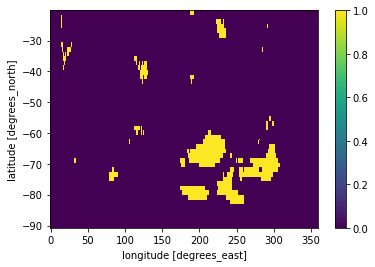

In [90]:
modify2_p_value_wdc_djf.plot()

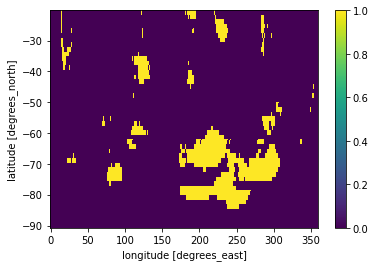

In [91]:
modify2_r2_value_wdc_djf.plot()

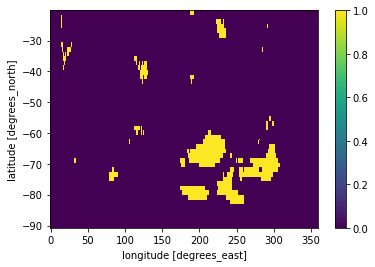

In [92]:
threshold_r2_p_value_wdc_djf.plot()

/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.949419453961331 -5.868271125017964


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.34555687090517 -7.912657864689322


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.9732498543960215 -5.88808600756497


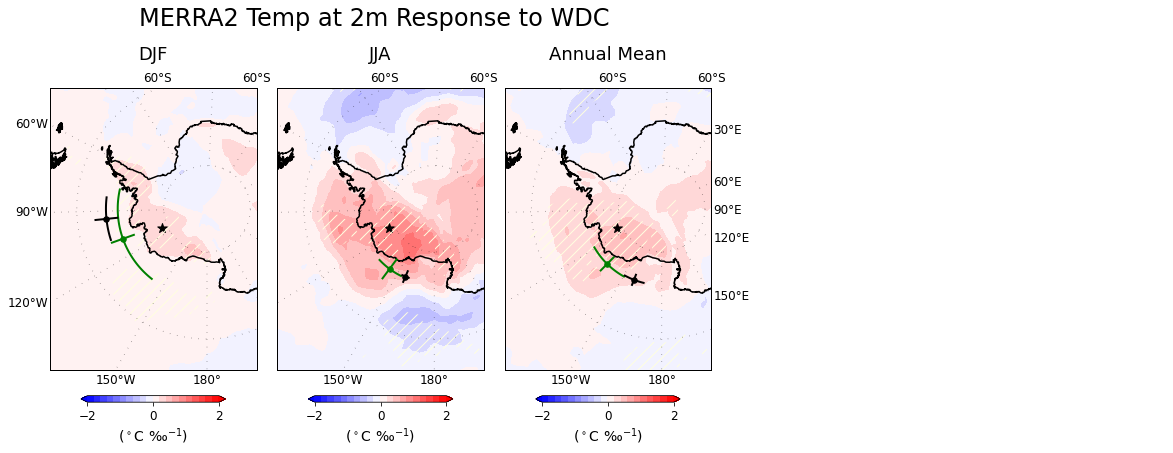

In [93]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA2 Temp at 2m Response to WDC', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_wdc_djf_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_wdc_jja_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_wdc_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-2.0,2.2,0.2)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)  
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_SAM_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_SAM_detrend_merra.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



# plt.savefig(FIG_PATH+'/New_Regression_Figure_iCESM_MERRA_TAGGED_t2m_Field_vs_WDC_20210324.ps',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [94]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_wdc_djf.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_djf.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_djf.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_wdc_jja.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_jja.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_jja.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_wdc_ann_mean.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_ann_mean.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_ann_mean.isel(lat=-9,lon=-75).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,0.238,0.154,0.087
JJA,0.864,0.237,0.025
ANN,0.467,0.316,0.008


# New Stuff to get ASL Position wrt PseudoCore Upper and Lower Quartile

## Time Series of d18O Anomalies at WDC

In [95]:
djf_d18O_at_WDC = df_WDC_djf_1982_2002_detrend.d18O_Recon_March #.values
djf_d18O_at_WDC

time
1982-12-01    2.018438
1983-12-01    0.216949
1984-12-01    2.206740
1985-12-01    0.205340
1986-12-01    2.224851
1987-12-01   -0.669390
1988-12-01   -0.299686
1989-12-01    0.731725
1990-12-01    3.337158
1991-12-01    2.770031
1992-12-01    0.478184
1993-12-01    4.894824
1994-12-01    5.268053
1995-12-01   -0.156025
1996-12-01    1.767215
1997-12-01   -0.977773
1998-12-01    0.052643
1999-12-01    2.155082
2000-12-01    2.137856
2001-12-01    2.008374
Freq: 12MS, Name: d18O_Recon_March, dtype: float64

In [96]:
jja_d18O_at_WDC = df_WDC_jja_1982_2002_detrend.d18O_Recon_March
jja_d18O_at_WDC

time
1982-06-01    1.374395
1983-06-01   -2.202162
1984-06-01   -0.226544
1985-06-01   -2.343583
1986-06-01   -3.215747
1987-06-01   -2.083568
1988-06-01   -3.763690
1989-06-01   -2.206858
1990-06-01    1.003571
1991-06-01   -1.421667
1992-06-01   -1.547256
1993-06-01   -1.274265
1994-06-01   -2.230123
1995-06-01   -2.118855
1996-06-01   -1.122279
1997-06-01   -2.317702
1998-06-01   -2.321419
1999-06-01   -2.236111
2000-06-01    0.444743
2001-06-01   -1.357904
2002-06-01   -1.224772
Freq: 12MS, Name: d18O_Recon_March, dtype: float64

In [97]:
ann_mean_d18O_at_WDC = df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March
ann_mean_d18O_at_WDC

time
1982-01-01    1.868674
1983-01-01   -0.890723
1984-01-01    0.815539
1985-01-01   -0.912345
1986-01-01   -0.794855
1987-01-01   -0.932070
1988-01-01   -2.075516
1989-01-01   -0.933758
1990-01-01    1.922385
1991-01-01    0.635763
1992-01-01   -0.215119
1993-01-01    1.220099
1994-01-01    1.361034
1995-01-01   -0.326099
1996-01-01    0.249667
1997-01-01   -1.402240
1998-01-01   -1.263486
1999-01-01   -0.409872
2000-01-01    1.462412
2001-01-01    0.276059
2002-01-01   -0.359703
Freq: AS-JAN, Name: d18O_Recon_March, dtype: float64

## Select Upper and Lower Indices wrt d18O at WDC

In [98]:

# djf
upperq_djf = djf_d18O_at_WDC.quantile(.75)
upperq_list_djf = djf_d18O_at_WDC.where(djf_d18O_at_WDC >= upperq_djf, np.nan).values
indices_for_upperq_djf = np.where(~np.isnan(upperq_list_djf))

lowerq_djf = djf_d18O_at_WDC.quantile(.25)
lowerq_list_djf = djf_d18O_at_WDC.where(djf_d18O_at_WDC <= lowerq_djf, np.nan).values
indices_for_lowerq_djf = np.where(~np.isnan(lowerq_list_djf))
# indices_for_lowerq_djf

# jja
upperq_jja = jja_d18O_at_WDC.quantile(.75)
upperq_list_jja = jja_d18O_at_WDC.where(jja_d18O_at_WDC >= upperq_jja, np.nan).values
indices_for_upperq_jja = np.where(~np.isnan(upperq_list_jja))

lowerq_jja = jja_d18O_at_WDC.quantile(.25)
lowerq_list_jja = jja_d18O_at_WDC.where(jja_d18O_at_WDC <= lowerq_jja, np.nan).values
indices_for_lowerq_jja = np.where(~np.isnan(lowerq_list_jja))
# indices_for_lowerq_jja

# ann_mean
upperq_ann_mean = ann_mean_d18O_at_WDC.quantile(.75)
upperq_list_ann_mean = ann_mean_d18O_at_WDC.where(ann_mean_d18O_at_WDC >= upperq_ann_mean, np.nan).values
indices_for_upperq_ann_mean = np.where(~np.isnan(upperq_list_ann_mean))

lowerq_ann_mean = ann_mean_d18O_at_WDC.quantile(.25)
lowerq_list_ann_mean = ann_mean_d18O_at_WDC.where(ann_mean_d18O_at_WDC <= lowerq_ann_mean, np.nan).values
indices_for_lowerq_ann_mean = np.where(~np.isnan(lowerq_list_ann_mean))
indices_for_lowerq_ann_mean

(array([ 3,  5,  6,  7, 15, 16]),)

In [99]:
ann_mean_d18O_at_WDC.where(ann_mean_d18O_at_WDC <= lowerq_ann_mean, np.nan)

time
1982-01-01         NaN
1983-01-01         NaN
1984-01-01         NaN
1985-01-01   -0.912345
1986-01-01         NaN
1987-01-01   -0.932070
1988-01-01   -2.075516
1989-01-01   -0.933758
1990-01-01         NaN
1991-01-01         NaN
1992-01-01         NaN
1993-01-01         NaN
1994-01-01         NaN
1995-01-01         NaN
1996-01-01         NaN
1997-01-01   -1.402240
1998-01-01   -1.263486
1999-01-01         NaN
2000-01-01         NaN
2001-01-01         NaN
2002-01-01         NaN
Freq: AS-JAN, Name: d18O_Recon_March, dtype: float64

In [100]:
#Select ASL Rel CP value, long, and lat while index is in upper or lower quartile
#Using new ASL info from 19Nov2018
#djf
djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[indices_for_upperq_djf]
# djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra

djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra = Rel_CP_djf_mean_indices_raw_merra.iloc[indices_for_lowerq_djf]
# djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra


#jja
jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[indices_for_upperq_jja]
# jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra

jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra = Rel_CP_jja_mean_indices_raw_merra.iloc[indices_for_lowerq_jja]
# jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra

#ann_mean
ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[indices_for_upperq_ann_mean]
# ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra

ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra = Rel_CP_ann_mean_indices_raw_merra.iloc[indices_for_lowerq_ann_mean]
ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra

,vals,lats,lons,sectormean,indice,abs_vals
time,,,,,,
1983-01-01,-5.715246,-70.5,253.5,985.146704,3,979.431458
1985-01-01,-6.377041,-73.5,214.5,984.389492,5,978.012451
1986-01-01,-5.511735,-75.0,207.0,988.455095,6,982.943359
1987-01-01,-4.600063,-73.5,202.5,986.560756,7,981.960693
1995-01-01,-5.311295,-73.5,202.5,986.198746,15,980.887451
1996-01-01,-5.848294,-69.0,256.5,984.984524,16,979.136230


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/cartopy/util.py:102: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  new_data = ma.concatenate((data, data[slicer]), axis=axis)
/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:39: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.009845850296278 -6.184292799449077


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:129: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-8.202243859611826 -8.599303453516427


/glade/work/pgoddard/NEW_ANACONDA_AND_PY_ENV_24Mar2021/geo_scipy/lib/python3.7/site-packages/ipykernel_launcher.py:217: MatplotlibDeprecationWarning: 
The dedent function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use inspect.cleandoc instead.


-5.593162908755498 -5.560612343586816


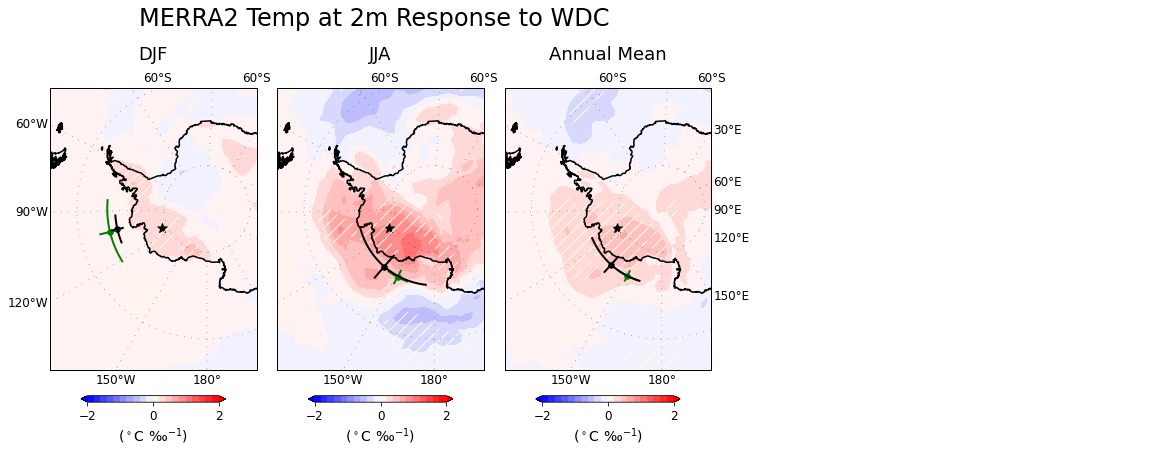

In [101]:
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,6), sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.0, wspace=0.1)
fig.suptitle('MERRA2 Temp at 2m Response to WDC', fontsize=24, y=1.05, x = 0.35)

# setup Lambert Conformal basemap.

# slope shades -- add cyclic
slope_djf_sh, lons = add_cyclic_point(slope_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_jja_sh, lons = add_cyclic_point(slope_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
slope_ann_mean_sh, lons = add_cyclic_point(slope_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# p-value contour -- add cyclic
p_value_djf_con, lons = add_cyclic_point(modify2_p_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_jja_con, lons = add_cyclic_point(modify2_p_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
p_value_ann_mean_con, lons = add_cyclic_point(modify2_p_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2-value contour -- add cyclic
r2_value_djf_con, lons = add_cyclic_point(modify2_r2_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_jja_con, lons = add_cyclic_point(modify2_r2_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
r2_value_ann_mean_con, lons = add_cyclic_point(modify2_r2_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)
# r2 and p-value threshold contour -- add cyclic
threshold_r2_p_value_wdc_djf_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_djf.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_wdc_jja_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_jja.values, MERRA_DATA.coords['lon'].values, axis=-1)
threshold_r2_p_value_wdc_ann_mean_con, lons = add_cyclic_point(threshold_r2_p_value_wdc_ann_mean.values, MERRA_DATA.coords['lon'].values, axis=-1)




lon, lat = np.meshgrid(lons,MERRA_DATA.coords['lat'].sel(lat=slice(shem_ylo, shem_yhi)).values)
levels = np.arange(-2.0,2.2,0.2)
levels_contour = [1]

parallels = np.arange(-80,-1,20)
meridians = np.arange(0,360,30.)
plt.rcParams['contour.negative_linestyle'] = 'solid'
plt.rcParams['text.latex.preamble']=[r"\usepackage{wasysym}"]

#DJF
plt.subplot(1, 5, 1)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[True,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_djf_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_djf_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_djf_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_djf_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean(),
            djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()+djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()-djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()+djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()-djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('DJF',y=1.08,fontsize=18)
print(djf_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.vals.mean(),djf_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.vals.mean())







#JJA
plt.subplot(1, 5, 2)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,False,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_jja_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_jja_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_jja_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_jja_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_jja_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean(),
            jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()+jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()-jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()+jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()-jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('JJA',y=1.08,fontsize=18)
print(jja_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.vals.mean(),jja_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.vals.mean())





#Annual Mean
plt.subplot(1, 5, 3)
m = Basemap(llcrnrlon=-135,llcrnrlat=-40,urcrnrlon=20,urcrnrlat=-60,projection='lcc',
            resolution='l',lat_1=-89.,lat_2=-65,lat_0=-70,lon_0=180.)
x, y = m(lon, lat)
# draw coastlines.
m.drawcoastlines(linewidth=1.5)
m.drawmapboundary(fill_color='white')
# labels = [left,right,top,bottom]
m.drawparallels(parallels,labels=[False,False,True,False],dashes=[.3, 7],fontsize=12)
m.drawmeridians(meridians,labels=[False,True,False,True],dashes=[.3, 7],fontsize=12)
CS = m.contourf(x,y,(slope_ann_mean_sh), levels, cmap=plt.cm.get_cmap('bwr'),extend='both')
#plt.ylabel('V10', fontsize=20)
cbar = plt.colorbar(orientation='horizontal', shrink=0.70, aspect=20, fraction=0.033, pad=0.08)
cbar.set_label(r'($^\circ$C ‰$^{-1}$)',size=14)  
cbar.set_ticks([-2.0, 0, 2.0])
cbar.ax.tick_params(labelsize=12)
plt.clim([-2.0,2.0])
#add point for central Psuedo cores
xpt,ypt = m(247.5, -78.63)
plt.scatter(xpt, ypt, c='k', marker='*', s=100)
# CS2 = m.contour(x,y,p_value_ann_mean_con,levels_contour,linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,r2_value_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
# CS2 = m.contour(x,y,threshold_r2_p_value_wdc_ann_mean_con, levels_contour, linewidths=0.35,colors='k')
mpl.rcParams['hatch.color'] = 'lightyellow' #use this line to change stipple color
CS2 = m.contourf(x, y, threshold_r2_p_value_wdc_ann_mean_con, levels = [0,0.5,1], hatches=['','//'], alpha=0)

#add Rel. CP mean location for upper and lower indice
#upper
xpt,ypt = m(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='green', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'
#lower
xpt,ypt = m(ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean(),
            ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
           )
plt.scatter(xpt, ypt, c='k', marker='o', s=30) #for value dependent: vmin=-10, vmax=0, cmap='green'

#Add +- 1std of long and lat
#upper
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, color='green', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='green', linewidth=2)
#lower
lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()+ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()-ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.std()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2) 

lat_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()+ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.mean()-ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lats.std()
                       ,100) 
lon_line = np.linspace(ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.lons.mean()
                       ,100)
x, y = m(lon_line, lat_line)
m.plot(x, y, c='k', linewidth=2)

# #add point for central Psuedo cores
# xpt,ypt = m(247.5, -78.63)
# plt.scatter(xpt, ypt, c='k', marker='*', s=100)

plt.title('Annual Mean',y=1.08,fontsize=18)
print(ann_mean_Rel_CP_indices_w_upper_d18O_at_WDC_detrend_merra.vals.mean(),ann_mean_Rel_CP_indices_w_lower_d18O_at_WDC_detrend_merra.vals.mean())



ax[-2].axis('off')
ax[-1].axis('off')



plt.savefig(FIG_PATH+'/New_Regression_Figure_iCESM_MERRA_TAGGED_t2m_Field_vs_WDC_20210417.pdf',bbox_inches='tight', pad_inches=0.05)




plt.show()

In [102]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_wdc_djf.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_djf.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_djf.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_wdc_jja.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_jja.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_jja.isel(lat=-9,lon=-75).values,3)},
        {'slope': np.round(slope_wdc_ann_mean.isel(lat=-9,lon=-75).values,3), 'r-sq': np.round(r2_value_wdc_ann_mean.isel(lat=-9,lon=-75).values,3), 'p-val':np.round(p_value_wdc_ann_mean.isel(lat=-9,lon=-75).values,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,0.238,0.154,0.087
JJA,0.864,0.237,0.025
ANN,0.467,0.316,0.008


# Get linear regression between WDC d18O timeseries and SAM, PSA1, PSA2 timeseries

In [103]:
SAM_djf_mean_merra['SAM'].values,

(array([ 0.03640599,  0.50144684, -1.38046289, -0.32549072, -0.76541887,
        -0.05034042, -0.29296768,  0.05038251,  0.75220166,  0.13515719,
         0.23313364, -1.19132232, -0.49716491,  0.63921508,  0.62346197,
         0.25719894, -0.20785424,  0.00914763,  0.7665661 ,  1.15889619]),)

In [104]:
df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values

array([ 2.01843765,  0.21694928,  2.20673966,  0.20533979,  2.22485145,
       -0.6693898 , -0.29968591,  0.73172545,  3.33715762,  2.77003135,
        0.47818379,  4.89482404,  5.2680531 , -0.1560247 ,  1.76721468,
       -0.97777347,  0.05264271,  2.15508208,  2.1378563 ,  2.008374  ])

#### Regress SAM onto WDC d18O time series

In [106]:
#Note, for the time series input, must select the column name and .values

##### SAM
###djf
slope_sam_wdc_djf, intercept_sam_wdc_djf, r_value_sam_wdc_djf, p_value_wdc_sam_djf, std_err_sam_wdc_djf = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_djf_mean_merra['SAM'].values,
                                                                                 df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_wdc_djf = r_value_sam_wdc_djf**2

###jja
slope_sam_wdc_jja, intercept_sam_wdc_jja, r_value_sam_wdc_jja, p_value_sam_wdc_jja, std_err_sam_wdc_jja = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_jja_mean_merra['SAM'].values,
                                                                                 df_WDC_jja_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_wdc_jja = r_value_sam_wdc_jja**2

###ann_mean
slope_sam_wdc_ann_mean, intercept_sam_wdc_ann_mean, r_value_sam_wdc_ann_mean, p_value_sam_wdc_ann_mean, std_err_sam_wdc_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 SAM_ann_mean_merra['SAM'].values,
                                                                                 df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_sam_wdc_ann_mean = r_value_sam_wdc_ann_mean**2

In [112]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_sam_wdc_djf,3), 'r-sq': np.round(r2_value_sam_wdc_djf,3), 'p-val':np.round(p_value_wdc_sam_djf,3)},
        {'slope': np.round(slope_sam_wdc_jja,3), 'r-sq': np.round(r2_value_sam_wdc_jja,3), 'p-val':np.round(p_value_sam_wdc_jja,3)},
        {'slope': np.round(slope_sam_wdc_ann_mean,3), 'r-sq': np.round(r2_value_sam_wdc_ann_mean,3), 'p-val':np.round(p_value_sam_wdc_ann_mean,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.730,0.075,0.241
JJA,0.175,0.012,0.642
ANN,-0.140,0.003,0.824


In [108]:
r2_value_sam_wdc_djf

0.0753540150440725

#### Regress PSA1 onto WDC d18O time series

In [113]:
#Note, for the time series input, must select the column name and .values

##### PSA1
###djf
slope_psa1_wdc_djf, intercept_psa1_wdc_djf, r_value_psa1_wdc_djf, p_value_wdc_psa1_djf, std_err_psa1_wdc_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_djf_mean_merra['PSA1'].values,
                                                                                 df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_wdc_djf = r_value_psa1_wdc_djf**2

###jja
slope_psa1_wdc_jja, intercept_psa1_wdc_jja, r_value_psa1_wdc_jja, p_value_psa1_wdc_jja, std_err_psa1_wdc_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_jja_mean_merra['PSA1'].values,
                                                                                 df_WDC_jja_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_wdc_jja = r_value_psa1_wdc_jja**2

###ann_mean
slope_psa1_wdc_ann_mean, intercept_psa1_wdc_ann_mean, r_value_psa1_wdc_ann_mean, p_value_psa1_wdc_ann_mean, std_err_psa1_wdc_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA1_ann_mean_merra['PSA1'].values,
                                                                                 df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa1_wdc_ann_mean = r_value_psa1_wdc_ann_mean**2

In [114]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_psa1_wdc_djf,3), 'r-sq': np.round(r2_value_psa1_wdc_djf,3), 'p-val':np.round(p_value_wdc_psa1_djf,3)},
        {'slope': np.round(slope_psa1_wdc_jja,3), 'r-sq': np.round(r2_value_psa1_wdc_jja,3), 'p-val':np.round(p_value_psa1_wdc_jja,3)},
        {'slope': np.round(slope_psa1_wdc_ann_mean,3), 'r-sq': np.round(r2_value_psa1_wdc_ann_mean,3), 'p-val':np.round(p_value_psa1_wdc_ann_mean,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,0.356,0.009,0.683
JJA,-0.825,0.306,0.009
ANN,-0.871,0.103,0.156


#### Regress PSA2 onto WDC d18O time series

In [115]:
#Note, for the time series input, must select the column name and .values

##### PSA2
###djf
slope_psa2_wdc_djf, intercept_psa2_wdc_djf, r_value_psa2_wdc_djf, p_value_wdc_psa2_djf, std_err_psa2_wdc_djf = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_djf_mean_merra['PSA2'].values,
                                                                                 df_WDC_djf_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_wdc_djf = r_value_psa2_wdc_djf**2

###jja
slope_psa2_wdc_jja, intercept_psa2_wdc_jja, r_value_psa2_wdc_jja, p_value_psa2_wdc_jja, std_err_psa2_wdc_jja = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_jja_mean_merra['PSA2'].values,
                                                                                 df_WDC_jja_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_wdc_jja = r_value_psa2_wdc_jja**2

###ann_mean
slope_psa2_wdc_ann_mean, intercept_psa2_wdc_ann_mean, r_value_psa2_wdc_ann_mean, p_value_psa2_wdc_ann_mean, std_err_psa2_wdc_ann_mean = xr.apply_ufunc(stats.linregress,
                                                                                 PSA2_ann_mean_merra['PSA2'].values,
                                                                                 df_WDC_ann_mean_1982_2002_detrend.d18O_Recon_March.values,
                                                                                 input_core_dims=[[''], ['time']], #note depending on name of time dimension this can change
                                                                                 output_core_dims=[[], [], [], [], []],
                                                                                 vectorize=True)
r2_value_psa2_wdc_ann_mean = r_value_psa2_wdc_ann_mean**2

In [116]:
#Indices for WDC location are lat = -9 and lon = -75
# Initialise data to lists.
data = [{'slope': np.round(slope_psa2_wdc_djf,3), 'r-sq': np.round(r2_value_psa2_wdc_djf,3), 'p-val':np.round(p_value_wdc_psa2_djf,3)},
        {'slope': np.round(slope_psa2_wdc_jja,3), 'r-sq': np.round(r2_value_psa2_wdc_jja,3), 'p-val':np.round(p_value_psa2_wdc_jja,3)},
        {'slope': np.round(slope_psa2_wdc_ann_mean,3), 'r-sq': np.round(r2_value_psa2_wdc_ann_mean,3), 'p-val':np.round(p_value_psa2_wdc_ann_mean,3)}]
  
# Creates DataFrame.
df = pd.DataFrame(data, index =['DJF', 'JJA', 'ANN'])
  
# Print the data
df

,slope,r-sq,p-val
DJF,-0.865,0.063,0.286
JJA,-0.810,0.256,0.019
ANN,-1.574,0.238,0.025
